# 1. Business Understanding
Starbucks Corporation is an American coffee company. Today, it operates more than 30,000 retail stores in 80 markets around the world.[1] The company hence is a big player in a vigorously competitive industry. One approach to retain customers is its Starbucks Reward Program. Members of the program receive promotional offers. The company then hopes to use the data collected on its customer behavior to create business value and make data-driven decisions on how it engages with its customers base.

# 1.1. Project Overview
Work in this notebook is to be submitted as a Udacity's Data Scientist capstone project. The motivation behind this project is to propose a solution that helps the company in forming a better understanding of its customers base. In this project, an unsupervised learning technique will be used to segment customers and measure how each segment behave during different periods of the test. In particular, K-Means clustering will be used. The provided dataset of courses will go through different phases at first before being ready for modeling. Starting with cleaning and ending with the final dataset grouped by customer profiles with their data aggreated.

Here's a high-level overview of the workflow followed in this project:

Define the problem in-hands and measurement criterias.
Explore, understand, and clean the provided datasets.
Prepare final dataset grouped by customers.
Transform final dataset appropriately before fitting model.
Fit model on final dataset and predict cluster labels.
Explore distributions among formed clusters.
Discuss outcomes and make recommendations.

# 1.2. Problem Statement¶
The company currently promotes products to customers with no prior knowledge of their segments. It is possible hence to analyse the data to find patterns in customer behaviors. This helps the company in aiming and tailoring its marketing efforts and resources to consumers who exhibit similar characteristics and are considered most likely to opt in for business's offerings. This form of target marketing is important because it helps the company by maximizing revenue while maintaining promotional campaigns cost smartly low. To do this, an unsupervised learning technique will be used to cluster customers into groups that can be be investigated separately to better understand their qualities and engage them accordingly.

# 1.3. Measurement Criterias
When speaking about measurement criterias, two categories come to mind; business metrics which assist in making decisions from a business point of view, and technical metrics which assist in making assessment of the implementation of the algorithm used to cluster data.

# 1.3.1. Business Metrics

All features will be investigated as much as possible, but there are two main themes used drive decisions made in this regard:

`1` Distinguish the difference between how customers behave during non-promotional periods and how they behave when they are prompted to do so during promotionals periods. To measure this, [**R**ecency-**F**requency-**M**onetary Analysis](https://en.wikipedia.org/wiki/RFM_(market_research)) for examining customer value is used. In this model, recency, frequency and monetary values are assigned a score from one to five based on quantiles partition dividing range of values into equal-sized intervals. The RFM score is then obtained by taking the average of all three scores.

$$\textrm{RFM}_{score}={\textrm{recency}_{score}+\textrm{frequency}_{score}+\textrm{monetary}_{score}\over3}$$ 

`2` Identify which customers react preferably to which types of offers. To measure this, offer view and completion rates will be used where the cardinalities of corresponding sets are divided by cardinalities of relevant sets.

$$\textrm{view rate}={n(\textrm{offer viewed})\over{n(\textrm{offer received})}}\;\;\;\;\;\;\;\;\textrm{completion rate}={n(\textrm{offer completed})\over{n(\textrm{offer viewed})}}$$

#### 1.3.1. Technical Metrics

For the algorithm chosen in this problem, K-Means, two appropriate methods will be used find the optimal number of clusters $k$ and to assess the model implementations; silhouette coefficient (SC) analysis and within-cluster Sum of Squared Errors (SSE) analysis.

`1` Silhouette Coefficient (SC) analysis is a way to measure how close each point in a cluster is to the points in its neighboring clusters. Its a neat way to find out the optimum value for k during k-means clustering. Silhouette values lies in the range of [-1, 1]. A value of +1 indicates that the sample is far away from its neighboring cluster and very close to the cluster its assigned. Similarly, value of -1 indicates that the point is close to its neighboring cluster than to the cluster its assigned. And, a value of 0 means at the boundary of the distance between the two cluster. Value of +1 is ideal and -1 is least preferred. Hence, higher the value better is the cluster configuration. [[2]](https://kapilddatascience.wordpress.com/2015/11/10/using-silhouette-analysis-for-selecting-the-number-of-cluster-for-k-means-clustering/)

Mathematically, for one data point $i$ where $a(i)$ represents the calculated mean distance of point $i$ with regard to to all other points in the cluster it was assigned and $b(i)$ represents the calculated mean distance of point $i$ with regard to to all points in its closest neighboring cluster, silhouette is defined:

$$s(i)={b(i)-a(i)\over\textrm{max}\{b(i),a(i))\}}$$

Therefore, it is clear from the above equation that $$-1\leq{s(i)}\leq1$$

Then, for one value representing the silhouette score that used for assessment of clustering outcomes, where $\bar{s}(k)$ represents the mean $s(i)$ over all data of the entire dataset for a specific number of clusters $k$, silhouette coefficient is defined:

$$SC=\textrm{max}_k\{\bar{s}(k)\}$$

`2` Sum of Squared Errors (SSE) analysis is a way to measure variability (dispersion) within a cluster by taking the sum of the squared differences between each data point and its cluster's mean, and therefore defined where $x_i$ is the $i$th data point and $n$ is the total number of data points: [[3]](https://hlab.stanford.edu/brian/error_sum_of_squares.html)

$$SSE=\sum_{i=1}^{n}x_i^2-{1\over{n}}\Bigg(\sum_{i=1}^{n}x_i^2\Bigg)^2$$

SSE tends to decrease toward 0 as $k$-value increase because then each data point is its own cluster and there is no error between it and the mean of its cluster. The elbow method is then applied by plotting SSE for a range of $k$-values where where one should choose a $k$-value after which variability starts to have diminishing returns. [[4]](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)

# 2. Data Understanding
This data set contains simulated data that mimics customer behavior on the Starbucks Rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink (informational) or an actual offer such as a discount or BOGO (buy one get one free). This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

The data is contained in three files mentioned below in brief and will be discussed in details later.

data/portfolio.json - containing meta data about the promotions offered by the company.
data/profile.json - demographic data about members enrolled in the reward program.
data/transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [1]:
import sys
sys.path.insert(0, '/content/utilities.py')
import utilities as u

from IPython.display import display
import pandas as pd
import numpy as np
import json
import time

In [2]:
from sklearn.preprocessing import PowerTransformer, MinMaxScaler
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')
%matplotlib inline

In [3]:
import warnings
import matplotlib.cbook
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
portfolio = pd.read_json(r"C:\Users\sansk\Downloads\Starbucks Customer Segmentation\Starbucks Customer Segmentation\datasets\portfolio.json",orient='records', lines=True)

In [5]:
profile = pd.read_json(r"C:\Users\sansk\Downloads\Starbucks Customer Segmentation\Starbucks Customer Segmentation\datasets\profile.json",orient='records', lines=True)

In [6]:
transcript = pd.read_json(r"C:\Users\sansk\Downloads\Starbucks Customer Segmentation\Starbucks Customer Segmentation\datasets\transcript.json",orient='records', lines=True)

### 2.1. portfolio Dataset
Schema:
0. id (str) - offer id

offer_type (str) - type of offer; bogo, discount, or informational
difficulty (int) - minimum required to be spent to complete an offer
reward (int) - reward given for completing an offer
duration (int) - time in days for an offer to be open
channels (list) - communication channels used to market an offer.


In [7]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [9]:
# Check null values
u.compute_null_pct(portfolio)

    column  count  pct
    reward      0  0.0
  channels      0  0.0
difficulty      0  0.0
  duration      0  0.0
offer_type      0  0.0
        id      0  0.0


### Conclusion:

This dataset contains meta data about promotions offered by the company. Every offer has a minimum required to be spent by a customer to complete an offer represented by difficulty and therfore be eligible for the reward. Also, every offer has a validity period represented by duration after which it expires.

The above is true for offers with offer type "bogo" and "discount". However, for "informational" offers while they have a duration, their difficulty and reward are zero since these offers are merely providing information about a product. This means they are not tracked for completion in transcript.

There are 10 rows (representing 10 types of offers) and 6 columns with no missing or null values. Very little cleaning will be performed on this dataset.

### 2.2. profile Dataset

#### Schema: 0. age (int) - age of the customer

became_member_on (int) - date when customer created an app account
gender (str) - gender of the customer; M, F, or O.
id (str) - customer id
income (float) - income of customer

In [10]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [11]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [12]:
u.compute_null_pct(profile)

          column  count   pct
          gender   2175 12.79
             age      0  0.00
              id      0  0.00
became_member_on      0  0.00
          income   2175 12.79


In [13]:
profile[profile.gender.isnull() == True].head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN
10,None,118,c4863c7985cf408faee930f111475da3,20170824,NaN
11,None,118,148adfcaa27d485b82f323aaaad036bd,20150919,NaN
17,None,118,744d603ef08c4f33af5a61c8c7628d1c,20170801,NaN
23,None,118,2b826eba31074a059d63b0ae8f50b7d5,20170907,NaN


In [14]:
# value_counts of `income` where `gender` is null
profile[profile.gender.isnull() == True].income.value_counts(dropna=False)

NaN    2175
Name: income, dtype: int64

In [15]:
# value_counts of `age` where `gender` is null
profile[profile.gender.isnull() == True].age.value_counts()

118    2175
Name: age, dtype: int64


This simply shows that for the the 2175 profiles where gender is null, income is also null, and age is set to 118. Indicating a problem with these records

Text(0.5, 1.0, 'Age Distribution')

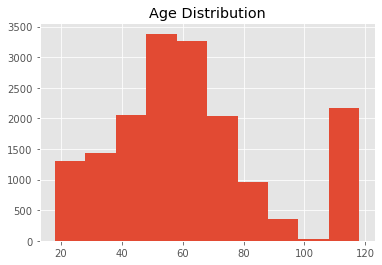

In [16]:
# Check `age` distribution
#plt.figure(figsize=(17,4))
plt.hist(profile.age);
plt.title('Age Distribution')

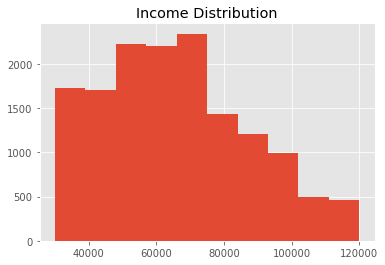

In [17]:
plt.hist(profile.income.dropna());
plt.title('Income Distribution');

In [ ]:
profile.gender.value_counts()

# Conclusion:

This dataset contains demographic data about members enrolled in the reward program with self-explanatory features. There are 17,000 rows (representing 17,000 customer profiles) and 5 columns. There are 2175 problematic rows with missing values and clear outliers. Aside from that, very little cleaning is required on this dataset.

### 2.2. transcript Dataset

###### Schema:
    

event (str) - record description; transaction, offer received, offer viewed, or offer completed.

person (str) - customer id.

value - (dict) - either an offer id or transaction amount depending on the record.

time (int) - time in hours since start of test. The data begins at time t=0.

In [19]:
transcript.tail()

,person,event,value,time
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714
306533,c02b10e8752c4d8e9b73f918558531f7,transaction,{'amount': 4.05},714


In [20]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [21]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [22]:
transcript.loc[transcript.event == 'transaction'].value.head()

12654    {'amount': 0.8300000000000001}
12657                 {'amount': 34.56}
12659                 {'amount': 13.23}
12670                 {'amount': 19.51}
12671                 {'amount': 18.97}
Name: value, dtype: object

In [23]:
transcript.loc[transcript.event == 'offer received'].value.head()

0    {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1    {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2    {'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3    {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
Name: value, dtype: object

In [24]:
transcript.loc[transcript.event == 'offer viewed'].value.head()

12650    {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
12651    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
12652    {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}
12653    {'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}
12655    {'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
Name: value, dtype: object

In [25]:
transcript.loc[transcript.event == 'offer completed'].value.head()

12658    {'offer_id': '2906b810c7d4411798c6938adc9daaa5...
12672    {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...
12679    {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...
12692    {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...
12697    {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...
Name: value, dtype: object

In [26]:
# Check test period
print(transcript.time.max(), 'hours')
print(transcript.time.max() / 24, 'days')

714 hours
29.75 days


#### Conclusion:

This dataset contains records of activities related to the test simulated. Each record is time-stamped since the start of the test. The test start at t=0 and ends at t=714 (≈ 30 days). The nature of each record is described using event. The value column holds a value based on the event column. For offer received, viewed, and completed, the offer id is recorded. For transaction, the amount is recorded. Although this dataset is somehow abstract, 306534 rows and 4 columns, most of the cleaning process will be performed on this dataset.

In [27]:

<img src="images/workflow.png" style="margin: 10px 0px"/>
<center>Figure 1: Overview of Dataframes Manipulation</center>

SyntaxError: invalid syntax (3251480246.py, line 1)

### 3.1. Data Cleaning

#### 3.1.1. portfolio Dataset
Starting be renaming columns id and reward to offer_id and offered_reward respectively. This serves readability. The latter in particular to make it distinguishable from a later added column redeemed_reward.

In [28]:
# Rename specified columns
portfolio.rename(columns={
    'id': 'offer_id',
    'reward': 'offered_reward'}, inplace=True)

One-hot encoding for columns channels and offer_type using utility function one_hot_encoder.

In [29]:
# One-hot encode `channel` column
portfolio = u.one_hot_encoder(
    df = portfolio,
    target_column = 'channels',
    categories = ['web','email','mobile','social'],
    prefix = 'channel')

# One-hot encode `offer_type` column
portfolio = u.one_hot_encoder(
    df = portfolio,
    target_column = 'offer_type',
    categories = ['discount','bogo','informational'],
    prefix = 'type')

Convert offer_id to integers, again for readability, while retaining the mapping dictionary later used to map offer ids in transcript. All done with help of utility function label_encoder.

In [30]:
# Convert `offer_id` to integers
portfolio, offer_id_dict = u.label_encoder(
    df = portfolio,
    target_column = 'offer_id',
    start = 1,
    step = 1)

In [31]:
offer_id_dict

{'ae264e3637204a6fb9bb56bc8210ddfd': 1,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 2,
 '3f207df678b143eea3cee63160fa8bed': 3,
 '9b98b8c7a33c4b65b9aebfe6a799e6d9': 4,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 'fafdcd668e3743c1bb461111dcafc2a4': 7,
 '5a8bc65990b245e5a138643cd4eb9837': 8,
 'f19421c1d4aa40978ebb69ca19b0e20d': 9,
 '2906b810c7d4411798c6938adc9daaa5': 10}

In [32]:
portfolio.head()

,offered_reward,difficulty,duration,offer_id,channel_web,channel_email,channel_mobile,channel_social,type_discount,type_bogo,type_informational
0,10,10,7,1,0,1,1,1,0,1,0
1,10,10,5,2,1,1,1,1,0,1,0
2,0,0,4,3,1,1,1,0,0,0,1
3,5,5,7,4,1,1,1,0,0,1,0
4,5,20,10,5,1,1,0,0,1,0,0


In [33]:
u.compute_null_pct(portfolio)

            column  count  pct
    offered_reward      0  0.0
        difficulty      0  0.0
          duration      0  0.0
          offer_id      0  0.0
       channel_web      0  0.0
     channel_email      0  0.0
    channel_mobile      0  0.0
    channel_social      0  0.0
     type_discount      0  0.0
         type_bogo      0  0.0
type_informational      0  0.0


#### 3.1.2. profile Dataset
Rename id column to customer_id

In [34]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

Convert became_member_on column to standard datetime object. This will be used then to add calculated days_member column and then dropped.

In [35]:
# Convert `became_member_on` to standard `datetime` object
profile.became_member_on = pd.to_datetime(profile.became_member_on, format='%Y%m%d')

# Add calculated 'days_member' column
profile['days_member'] = (pd.to_datetime('today') - profile['became_member_on']).astype('timedelta64[D]').astype(int)

# Drop `became_member_on`
profile.drop(columns='became_member_on', inplace=True)

In regards to the 2175 profiles with missing values discussed earlier, the decision was to simply drop them. Also, dropping 212 profiles with 'other' gender. This to make it much easier to just remap 'male' and 'female' gender with binary values in one column. It's important to retain their ids in order to later remove corresponding activies in transcript.

In [36]:
# Retain `customer_id` of rows to be deleted to later remove corresponding rows in `transcript`
dropped_profiles = profile[
    (profile.gender.isnull() == True) | (profile.gender == 'O')].customer_id.values

# Drop rows using the list produced in `dropped_profiles` above
profile.drop(profile[profile.customer_id.isin(dropped_profiles) == True].index, inplace=True)

# Reset index
profile.reset_index(drop=True, inplace=True)

Now gender column can be simply remapped using binary values.

In [37]:
# Remap `gender` column using binary values
profile.gender = profile.gender.map({'F':0, 'M':1})

Convert customer_id to integers, again for readability, while retaining the mapping dictionary later used to map customer ids in transcript. All done with help of utility function label_encoder.

In [38]:
# Convert `customer_id` to integers
profile, customer_id_dict = u.label_encoder(
    df = profile,
    target_column = 'customer_id',
    start = 1,
    step = 1)

In [39]:
dict(list(customer_id_dict.items())[0:5])

{'0610b486422d4921ae7d2bf64640c50b': 1,
 '78afa995795e4d85b5d9ceeca43f5fef': 2,
 'e2127556f4f64592b11af22de27a7932': 3,
 '389bc3fa690240e798340f5a15918d5c': 4,
 '2eeac8d8feae4a8cad5a6af0499a211d': 5}

In [40]:
profile.head()

,gender,age,customer_id,income,days_member
0,0,55,1,112000.0,2586
1,0,75,2,100000.0,2653
2,1,68,3,70000.0,2301
3,1,65,4,53000.0,2377
4,1,58,5,51000.0,2467


In [41]:
u.compute_null_pct(profile)

     column  count  pct
     gender      0  0.0
        age      0  0.0
customer_id      0  0.0
     income      0  0.0
days_member      0  0.0


#### 3.1.2. transcript Dataset

In [42]:
# Rename `person` column to `customer_id`
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

Drop rows with customer_id corresponding to deleted users in profile.

In [43]:
# Drop rows with `customer_id` corresponding to deleted users in `profile`
transcript = transcript[transcript.customer_id.isin(dropped_profiles) == False]

In [44]:
# Map `customer_id` with previously created `customer_id_dict`
transcript.customer_id = transcript.customer_id.apply(lambda x: customer_id_dict[x])

To deal with value column, two new columns are created. value_type and actual_value. Their entries are derived by applying a function along each row to extract and hence separate data. Original value column is then dropped

In [45]:
transcript.head()

,customer_id,event,value,time
0,2,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,3,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,4,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,5,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,6,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [46]:
# Add column `value_type`
transcript['value_type'] = transcript.value.apply(lambda x : list(x.keys())[0])

# Add column `actual_value`
transcript['actual_value'] = transcript.value.apply(lambda x : list(x.values())[0])

# Drop `value` column
transcript.drop(columns='value', inplace=True)

In [47]:
transcript

,customer_id,event,time,value_type,actual_value
0,2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,3,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
5,4,offer received,0,offer id,f19421c1d4aa40978ebb69ca19b0e20d
7,5,offer received,0,offer id,3f207df678b143eea3cee63160fa8bed
8,6,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7
...,...,...,...,...,...
306527,14572,offer completed,714,offer_id,fafdcd668e3743c1bb461111dcafc2a4
306529,14580,transaction,714,amount,1.59
306530,14585,transaction,714,amount,9.53
306531,14598,transaction,714,amount,3.61


In [48]:
# Split `transcript` dataset into offer and transaction
offers_df = transcript[transcript['event'] != 'transaction']
transactions_df = transcript[transcript['event'] == 'transaction']

Now, column actual_value can be renamed in each dataframe accordingly. In offers_df will be renamed to offer_id, and in transactions_df will be renamed to amount.

In [49]:
# Rename columns
offers_df.rename(columns={'actual_value': 'offer_id'}, inplace=True)
transactions_df.rename(columns={'actual_value': 'amount'}, inplace=True)

Due to this split, some coulmns are no longer needed. value_type in offers_df. event and value_type in transactions_df. These columns are to be dropped. the value column was separated

In [50]:
transactions_df.head()

,customer_id,event,time,value_type,amount
12654,28,transaction,0,amount,0.83
12657,39,transaction,0,amount,34.56
12659,45,transaction,0,amount,13.23
12670,107,transaction,0,amount,19.51
12671,123,transaction,0,amount,18.97


In [51]:
offers_df.head()

,customer_id,event,time,value_type,offer_id
0,2,offer received,0,offer id,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,3,offer received,0,offer id,2906b810c7d4411798c6938adc9daaa5
5,4,offer received,0,offer id,f19421c1d4aa40978ebb69ca19b0e20d
7,5,offer received,0,offer id,3f207df678b143eea3cee63160fa8bed
8,6,offer received,0,offer id,0b1e1539f2cc45b7b9fa7c272da2e1d7


Due to this split, some coulmns are no longer needed. value_type in offers_df. event and value_type in transactions_df. These columns are to be dropped. the value column was separated

In [52]:
# Drop unnecessary columns
offers_df.drop(columns='value_type', inplace=True)
transactions_df.drop(columns=['value_type', 'event'], inplace=True)

In [53]:
# Map `offer_id` with previously created `offer_id_dict`
offers_df.offer_id = offers_df.offer_id.apply(lambda x: offer_id_dict[x])

In [54]:
offers_df.head()

,customer_id,event,time,offer_id
0,2,offer received,0,4
2,3,offer received,0,10
5,4,offer received,0,9
7,5,offer received,0,3
8,6,offer received,0,5


In [55]:
u.compute_null_pct(offers_df)

     column  count  pct
customer_id      0  0.0
      event      0  0.0
       time      0  0.0
   offer_id      0  0.0


In [56]:
transactions_df.head()

,customer_id,time,amount
12654,28,0,0.83
12657,39,0,34.56
12659,45,0,13.23
12670,107,0,19.51
12671,123,0,18.97


In [58]:
u.compute_null_pct(transactions_df)

     column  count  pct
customer_id      0  0.0
       time      0  0.0
     amount      0  0.0


### 3.2. Data Preprocessing
Now that the four dataframes, portfolio, profile, offers_df, and transactions_df are cleaned. The process of merging and aggregating data can proceed.

The first step is merge portfolio to offers_df.

In [59]:
# Merge `portfolio` to `offers_df`
offers_df = pd.merge(offers_df, portfolio, on='offer_id')

In [60]:
offers_df.head()

,customer_id,event,time,offer_id,offered_reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,type_discount,type_bogo,type_informational
0,2,offer received,0,4,5,5,7,1,1,1,0,0,1,0
1,19,offer received,0,4,5,5,7,1,1,1,0,0,1,0
2,23,offer received,0,4,5,5,7,1,1,1,0,0,1,0
3,29,offer received,0,4,5,5,7,1,1,1,0,0,1,0
4,32,offer received,0,4,5,5,7,1,1,1,0,0,1,0


In [61]:
# Split `offers_df` based on `event`
received_df = offers_df[offers_df['event']=='offer received']
viewed_df = offers_df[offers_df['event']=='offer viewed']
completed_df = offers_df[offers_df['event']=='offer completed']


To keep things clean, new auxiliary dataframe aux_df is created as a copy of received_df which will be the workspace for all preprocessing steps. Many of the columns created in this dataframe will not make it to the final dataframe grouped by customer profiles but they are useful in logical operations.

In [62]:
# Create aux_df: a copy of received_df
aux_df = received_df.copy()

Since aux_df is nothing but a copy of received_df. Simply the event column which only contains the value ‘offer_recieved’ can be renamed to offer_recieved with a value of 1.

In [63]:
# Rename `event` to `offer_received` in `aux_df`
aux_df.rename(columns={'event': 'offer_received'}, inplace=True)
aux_df.offer_received = 1

aux_df.offer_received = 1
In aux_df, two new columns will serve as the base for all logical tests later. offer_start_time which is nothing but the already existing time column. Hence, time will be renamed to offer_start_time. The other one is offer_end_time which can be easily obtained by adding the offer duratin (in hours) to offer_start_time.

In [64]:
aux_df.head()

,customer_id,offer_received,time,offer_id,offered_reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,type_discount,type_bogo,type_informational
0,2,1,0,4,5,5,7,1,1,1,0,0,1,0
1,19,1,0,4,5,5,7,1,1,1,0,0,1,0
2,23,1,0,4,5,5,7,1,1,1,0,0,1,0
3,29,1,0,4,5,5,7,1,1,1,0,0,1,0
4,32,1,0,4,5,5,7,1,1,1,0,0,1,0


In aux_df, two new columns will serve as the base for all logical tests later. offer_start_time which is nothing but the already existing time column. Hence, time will be renamed to offer_start_time. The other one is offer_end_time which can be easily obtained by adding the offer duratin (in hours) to offer_start_time.

In [65]:
# Rename `time` to `offer_start_time` and add `offer_end_time`
aux_df.rename(columns={'time': 'offer_start_time'}, inplace=True)
aux_df['offer_end_time'] = aux_df.offer_start_time + aux_df.duration * 24

Now that the start and end time for each offer received in aux_df are present, a utility function get_offer_engagements will be applied along each row. This function takes other dataframes (viewed_df, completed_df, transactions_df) and extract necessary data. The function then returns a list in the form of [offer_viewed_time, offer_completed_time]. If any was missing or invaild, returns NaN in its corresponding place inside the list. Then, another utility function expand_list_to_columns is used to expand the output value returnd into separate columns.

It is important here to go over the assumption programmed into the function get_offer_engagements for a view or completion time to be valid.

An offer is considered viewed only if done so after it has been received and during offer's duration. That means the conditions for a valid view time:

1).offer_viewed_time >= offer_start_time, and
2)offer_viewed_time <= offer_end_time

An offer is considered _**completed**_ depending on the offer type:
* For bogo and discount offers, `completed_df` dataframe is used extract necessary info. The completion time must be after the time it has been viewed and during offer's duration. That means the conditions for a valid complete time in this case:
    1. `offer_completed_time >= offer_viewed_time`, and
    2. `offer_completed_time <= offer_end_time`


* For informational offers, `transactions_df` is used to extract necessary info. The way completion for informational offers is measured is by checking if the customer has made any transaction after viewing the offer and in offer's duration which assumed earlier to be the period of influence. That means the conditions for a valid complete time in this case:
    1. `transaction_time >= offer_viewed_time`, and
    2. `transaction_time <= offer_end_time`

In [66]:
aux_df.head()

,customer_id,offer_received,offer_start_time,offer_id,offered_reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,type_discount,type_bogo,type_informational,offer_end_time
0,2,1,0,4,5,5,7,1,1,1,0,0,1,0,168
1,19,1,0,4,5,5,7,1,1,1,0,0,1,0,168
2,23,1,0,4,5,5,7,1,1,1,0,0,1,0,168
3,29,1,0,4,5,5,7,1,1,1,0,0,1,0,168
4,32,1,0,4,5,5,7,1,1,1,0,0,1,0,168


In [67]:
# Add empty object column to store `output_value` list of function
aux_df['output_value'] = ''

# Apply u.get_offer_engagements to each row
aux_df.output_value = aux_df.apply(
    lambda x: u.get_offer_engagements(x, viewed_df, completed_df, transactions_df), axis=1)

# Expand `output_value` list to columns
aux_df = u.expand_list_to_columns(aux_df, 'output_value', {
    0: 'offer_viewed_time',
    1: 'offer_completed_time'})

In [68]:
transactions_df.head()

,customer_id,time,amount
12654,28,0,0.83
12657,39,0,34.56
12659,45,0,13.23
12670,107,0,19.51
12671,123,0,18.97


In [69]:
aux_df.head()

,offer_viewed_time,offer_completed_time,customer_id,offer_received,offer_start_time,offer_id,offered_reward,difficulty,duration,channel_web,channel_email,channel_mobile,channel_social,type_discount,type_bogo,type_informational,offer_end_time
0,6.0,132.0,2,1,0,4,5,5,7,1,1,1,0,0,1,0,168
1,NaN,NaN,19,1,0,4,5,5,7,1,1,1,0,0,1,0,168
2,48.0,NaN,23,1,0,4,5,5,7,1,1,1,0,0,1,0,168
3,30.0,66.0,29,1,0,4,5,5,7,1,1,1,0,0,1,0,168
4,NaN,NaN,32,1,0,4,5,5,7,1,1,1,0,0,1,0,168


In [ ]:
aux_df[aux_df['type_informational']==1]

In [70]:
aux_df[['offer_start_time', 'offer_end_time', 'offer_viewed_time', 'offer_completed_time']].head(15)

,offer_start_time,offer_end_time,offer_viewed_time,offer_completed_time
0,0,168,6.0,132.0
1,0,168,NaN,NaN
2,0,168,48.0,NaN
3,0,168,30.0,66.0
4,0,168,NaN,NaN
5,0,168,18.0,NaN
6,0,168,96.0,156.0
7,0,168,NaN,NaN
8,0,168,NaN,NaN
9,0,168,NaN,NaN


One feature that will be added is response_score which measures how fast a customer responded to an offer once viewed. The score is normalized using offer's duration and range from 0 to 1. The higher the score, the faster responsivity to an offer.

In [ ]:
aux_df.head()

In [71]:
aux_df['response_score'] = (
    aux_df.offer_completed_time -
    aux_df.offer_viewed_time).apply(
    lambda x: x if x >= 0 else np.NaN)

In [72]:
aux_df.response_score = np.round(((
    (aux_df.duration * 24) - aux_df.response_score) /
    (aux_df.duration * 24)), 2).fillna(0)

In [73]:
aux_df[['offer_viewed_time', 'offer_completed_time', 'response_score']].head(15)

,offer_viewed_time,offer_completed_time,response_score
0,6.0,132.0,0.25
1,NaN,NaN,0.00
2,48.0,NaN,0.00
3,30.0,66.0,0.79
4,NaN,NaN,0.00
5,18.0,NaN,0.00
6,96.0,156.0,0.64
7,NaN,NaN,0.00
8,NaN,NaN,0.00
9,NaN,NaN,0.00


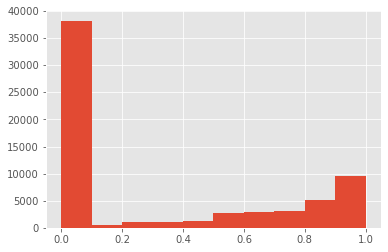

In [74]:
aux_df.response_score.hist();

Since the view and compeltion time is now present, two new columns offer_viewed and offer_completed with binery values will be added.

In [75]:
# Add `offer_viewed` and `offer_completed` columns with binery values
aux_df['offer_viewed'] = aux_df.offer_viewed_time.apply(lambda x: 0 if pd.isnull(x) else 1)
aux_df['offer_completed'] = aux_df.offer_completed_time.apply(lambda x: 0 if pd.isnull(x) else 1)

In [76]:
aux_df[['offer_viewed_time', 'offer_completed_time', 'offer_viewed', 'offer_completed']].head()

,offer_viewed_time,offer_completed_time,offer_viewed,offer_completed
0,6.0,132.0,1,1
1,NaN,NaN,0,0
2,48.0,NaN,1,0
3,30.0,66.0,1,1
4,NaN,NaN,0,0



New redeemed_reward columns is added by simply multiplying offered_reward by offer_completed.

In [77]:
# Add `redeemed_reward` columns
aux_df['redeemed_reward'] = aux_df.offered_reward * aux_df.offer_completed

To make things clean, three temprary (dummy) dataframes are created. Named alpha_df, beta_df, and gamma_df. In the first two, selection of columns are used and aggregated by sum and mean respectively. In the last, utility function split_columns_by_offer_type is used on a selection of columns to aggregate data by offer type.

In [78]:

alpha_df = aux_df[[
    'customer_id',
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'channel_web',
    'channel_email',
    'channel_mobile',
    'channel_social',
    ]].groupby('customer_id', as_index=True).sum().fillna(0)

beta_df = aux_df[[
    'customer_id',
    'difficulty',
    'duration',
    'offered_reward',
    'redeemed_reward',
    'response_score',
    ]].groupby('customer_id', as_index=True).mean().fillna(0)

Now, creating the final datframe coe which will be used for modeling by megring the above dataframes alpha_df, beta_df, and gamma_df to profile.

In [79]:
alpha_df.head()

,offer_received,offer_viewed,offer_completed,channel_web,channel_email,channel_mobile,channel_social
customer_id,,,,,,,
1,2,0,0,2,2,2,0
2,4,4,3,2,4,4,3
3,4,3,2,4,4,4,1
4,6,6,5,6,6,6,3
5,3,2,1,3,3,3,2


In [80]:
beta_df.head()

,difficulty,duration,offered_reward,redeemed_reward,response_score
customer_id,,,,,
1,2.500000,5.500000,2.500000,0.000000,0.000000
2,5.000000,5.500000,5.000000,3.750000,0.390000
3,6.250000,7.000000,2.250000,1.750000,0.347500
4,6.666667,6.833333,4.000000,3.166667,0.405000
5,5.666667,7.000000,1.666667,0.666667,0.183333


In [81]:
gamma_df = u.split_columns_by_offer_type(aux_df, [
    'offer_received',
    'offer_viewed',
    'offer_completed',
    'response_score',
    ])

In [82]:
gamma_df.head()

,bogo_offer_received,disc_offer_received,info_offer_received,bogo_offer_viewed,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score
customer_id,,,,,,,,,,,,
1,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
2,3,0,1,3.0,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92
3,1,2,1,1.0,2.0,0.0,1.0,1.0,0.0,0.39,1.00,0.00
4,2,2,0,2.0,2.0,0.0,1.5,2.0,0.0,0.67,1.09,0.00
5,0,2,1,0.0,2.0,0.0,0.0,1.0,0.0,0.00,0.55,0.00



Now, creating the final datframe `coe` which will be used for modeling by megring the above dataframes `alpha_df`, `beta_df`, and `gamma_df` to `profile`.


In [83]:
# Create the final dataset `coe`
coe = pd.merge(profile.set_index('customer_id'), alpha_df, left_index=True, right_index=True)
coe = pd.merge(coe, beta_df, left_index=True, right_index=True)
coe = pd.merge(coe, gamma_df, left_index=True, right_index=True)

In [84]:
coe.reset_index(inplace=True)

In [85]:
coe.head()

,customer_id,gender,age,income,days_member,offer_received,offer_viewed,offer_completed,channel_web,channel_email,channel_mobile,channel_social,difficulty,duration,offered_reward,redeemed_reward,response_score,bogo_offer_received,disc_offer_received,info_offer_received,bogo_offer_viewed,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score
0,1,0,55,112000.0,2586,2,0,0,2,2,2,0,2.500000,5.500000,2.500000,0.000000,0.000000,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
1,2,0,75,100000.0,2653,4,4,3,2,4,4,3,5.000000,5.500000,5.000000,3.750000,0.390000,3,0,1,3.0,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92
2,3,1,68,70000.0,2301,4,3,2,4,4,4,1,6.250000,7.000000,2.250000,1.750000,0.347500,1,2,1,1.0,2.0,0.0,1.0,1.0,0.0,0.39,1.00,0.00
3,4,1,65,53000.0,2377,6,6,5,6,6,6,3,6.666667,6.833333,4.000000,3.166667,0.405000,2,2,0,2.0,2.0,0.0,1.5,2.0,0.0,0.67,1.09,0.00
4,5,1,58,51000.0,2467,3,2,1,3,3,3,2,5.666667,7.000000,1.666667,0.666667,0.183333,0,2,1,0.0,2.0,0.0,0.0,1.0,0.0,0.00,0.55,0.00


In this step below, sets of new features will be added using utility function `get_transactions_allotment` that will be helpful in measuring the two main points discussed in _problem statement_. The nomenclature for these features is as follows:

* Prefixes
    * `txn_`: Count of transactions.
    * `amt_`: Sum of amount.
    * `recency_`: Time of most recent transaction.
    * `frequency_`: Average time in hours between transactions.
    * `monetary_`: Average amount per transaction.
* Suffixes
    * `_overall`: Anytime during the test period.
    * `_promo`: During offer durations (regardless of view or completion).
    * `_nonpromo`: In-between (outside) offers durations

The set of `frequency_`, `recency_`, and `monetary_` features is necessary to calculate the RFM score. This [article](https://clevertap.com/blog/rfm-analysis/) was a nice guide in doing so.

In [86]:
# Add empty object column to store `output_value` list of function
coe['output_value'] = ''

# Apply u.get_transactions_allotment to each row
coe.output_value = coe.apply(
    lambda x: u.get_transactions_allotment(x, aux_df, transactions_df), axis=1)

# Expand `output_value` list to columns
coe = u.expand_list_to_columns(coe, 'output_value', {
    0: 'txn_overall',
    1: 'amt_overall',
    2: 'txn_promo',
    3: 'amt_promo',
    4: 'txn_nonpromo',
    5: 'amt_nonpromo',
    6: 'recency_promo',
    7: 'recency_nonpromo'})

In [87]:
coe.head()

,txn_overall,amt_overall,txn_promo,amt_promo,txn_nonpromo,amt_nonpromo,recency_promo,recency_nonpromo,customer_id,gender,age,income,days_member,offer_received,offer_viewed,offer_completed,channel_web,channel_email,channel_mobile,channel_social,difficulty,duration,offered_reward,redeemed_reward,response_score,bogo_offer_received,disc_offer_received,info_offer_received,bogo_offer_viewed,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score
0,3.0,77.01,1.0,23.22,2.0,53.79,528.0,144.0,1,0,55,112000.0,2586,2,0,0,2,2,2,0,2.500000,5.500000,2.500000,0.000000,0.000000,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00
1,7.0,159.27,6.0,135.34,1.0,23.93,222.0,378.0,2,0,75,100000.0,2653,4,4,3,2,4,4,3,5.000000,5.500000,5.000000,3.750000,0.390000,3,0,1,3.0,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92
2,3.0,57.73,1.0,18.42,2.0,39.31,522.0,294.0,3,1,68,70000.0,2301,4,3,2,4,4,4,1,6.250000,7.000000,2.250000,1.750000,0.347500,1,2,1,1.0,2.0,0.0,1.0,1.0,0.0,0.39,1.00,0.00
3,3.0,36.43,3.0,36.43,0.0,0.00,60.0,NaN,4,1,65,53000.0,2377,6,6,5,6,6,6,3,6.666667,6.833333,4.000000,3.166667,0.405000,2,2,0,2.0,2.0,0.0,1.5,2.0,0.0,0.67,1.09,0.00
4,4.0,15.62,4.0,15.62,0.0,0.00,216.0,NaN,5,1,58,51000.0,2467,3,2,1,3,3,3,2,5.666667,7.000000,1.666667,0.666667,0.183333,0,2,1,0.0,2.0,0.0,0.0,1.0,0.0,0.00,0.55,0.00


In [88]:
# Add remaining required components for RFM score
coe['monetary_promo'] = np.round(coe.amt_promo / coe.txn_promo, 2)
coe['monetary_nonpromo'] = np.round(coe.amt_nonpromo / coe.txn_nonpromo, 2)

coe['frequency_promo'] = np.round(coe.recency_promo / coe.txn_promo, 2)
coe['frequency_nonpromo'] = np.round(coe.recency_nonpromo / coe.txn_promo, 2)

Now that the basies for RFM paradigm are present, utility function add_rfm_scores will be used to calculate the RFM score. This function uses pd.qcut to rank values in each column of frequency_..., recency_..., and monetary_... in 5 bins. Then, for each custmer, average of relevant values are obtained. The results are stored in two new columns rfm_promo_score and rfm_nonpromo_score with the original columns dropped from the dataframe. The scores ranges from 0 to 5. Starting from 0 which indicates no activity at all. Going up, the higher the better customer value.

In [89]:
# Run u.add_rfm_paradigm on the dataset to perform necessary computations
coe = u.add_rfm_scores(coe)

In [90]:
coe[['rfm_promo_score', 'rfm_nonpromo_score']].head()

,rfm_promo_score,rfm_nonpromo_score
0,4.67,4.00
1,2.67,4.33
2,4.33,4.00
3,1.67,0.00
4,2.33,0.00


In [91]:
coe.head()

,txn_overall,amt_overall,txn_promo,amt_promo,txn_nonpromo,amt_nonpromo,customer_id,gender,age,income,days_member,offer_received,offer_viewed,offer_completed,channel_web,channel_email,channel_mobile,channel_social,difficulty,duration,offered_reward,redeemed_reward,response_score,bogo_offer_received,disc_offer_received,info_offer_received,bogo_offer_viewed,disc_offer_viewed,info_offer_viewed,bogo_offer_completed,disc_offer_completed,info_offer_completed,bogo_response_score,disc_response_score,info_response_score,rfm_promo_score,rfm_nonpromo_score
0,3.0,77.01,1.0,23.22,2.0,53.79,1,0,55,112000.0,2586,2,0,0,2,2,2,0,2.500000,5.500000,2.500000,0.000000,0.000000,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,4.67,4.00
1,7.0,159.27,6.0,135.34,1.0,23.93,2,0,75,100000.0,2653,4,4,3,2,4,4,3,5.000000,5.500000,5.000000,3.750000,0.390000,3,0,1,3.0,0.0,1.0,2.0,0.0,1.0,0.64,0.00,0.92,2.67,4.33
2,3.0,57.73,1.0,18.42,2.0,39.31,3,1,68,70000.0,2301,4,3,2,4,4,4,1,6.250000,7.000000,2.250000,1.750000,0.347500,1,2,1,1.0,2.0,0.0,1.0,1.0,0.0,0.39,1.00,0.00,4.33,4.00
3,3.0,36.43,3.0,36.43,0.0,0.00,4,1,65,53000.0,2377,6,6,5,6,6,6,3,6.666667,6.833333,4.000000,3.166667,0.405000,2,2,0,2.0,2.0,0.0,1.5,2.0,0.0,0.67,1.09,0.00,1.67,0.00
4,4.0,15.62,4.0,15.62,0.0,0.00,5,1,58,51000.0,2467,3,2,1,3,3,3,2,5.666667,7.000000,1.666667,0.666667,0.183333,0,2,1,0.0,2.0,0.0,0.0,1.0,0.0,0.00,0.55,0.00,2.33,0.00



Three more features are added; amt_per_test_hour: avergae spent during the test period per hour, amt_per_member_day: avergae spent during the test period per number of membrship days, and amt_per_income: avergae spent during the test period per income.

In [92]:
# Add three more calculated columns describing customers attributes
coe['amt_per_test_hour'] = np.round(coe.amt_overall / transactions_df.time.max(), 6)
coe['amt_per_member_day'] = np.round(coe.amt_overall / coe.days_member, 6)
coe['amt_per_income'] = np.round(coe.amt_overall / coe.income, 6)

Final step is to drop customer_id column.

In [93]:
# Drop 'customer_id' column; not needed in the model
coe.drop(columns='customer_id', inplace=True)

At this point, dataframe coe is ready to be used for modeling to perform customer segmentation. It has 39 features and 14608 samples. All features are numerical except gender which is a categorical feature represented by binary values.

In [94]:
coe.shape

(14608, 39)

In [95]:
coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14608 entries, 0 to 14607
Data columns (total 39 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   txn_overall           14608 non-null  float64
 1   amt_overall           14608 non-null  float64
 2   txn_promo             14608 non-null  float64
 3   amt_promo             14608 non-null  float64
 4   txn_nonpromo          14608 non-null  float64
 5   amt_nonpromo          14608 non-null  float64
 6   gender                14608 non-null  int64  
 7   age                   14608 non-null  int64  
 8   income                14608 non-null  float64
 9   days_member           14608 non-null  int32  
 10  offer_received        14608 non-null  int64  
 11  offer_viewed          14608 non-null  int64  
 12  offer_completed       14608 non-null  int64  
 13  channel_web           14608 non-null  int64  
 14  channel_email         14608 non-null  int64  
 15  channel_mobile     

**Schema:**
* `txn_overall`: Count of transactions made anytime during the test. 
* `amt_overall`: Sum of amount spent anytime during the test.
* `txn_promo`: Count of transactions made during offer durations (regardless of view or completion). 
* `amt_promo`: Sum of amount spent during offer durations (regardless of view or completion).
* `txn_nonpromo`: Count of transactions in-between (outside) offers durations.
* `amt_nonpromo`: Sum of amount spent in-between (outside) offers durations.
* `gender`: Customer's gender {0: Female, 1:Male}
* `age`: Customer's age.
* `income`: Customer's income.
* `days_member`: Number of days as a member of the program (dynamic; as of today's date).
* `offer_received`: Count of total offers received.
* `offer_viewed`: Count of total offers viewed.
* `offer_completed`: Count of total offers completed.
* `channel_web`: Count of total offer received via web.
* `channel_email`: Count of total offer received via email.
* `channel_mobile`: Count of total offer received via mobile.
* `channel_social`: Count of total offer received via social.
* `difficulty`: Average of minimum required to be spent for all offers received.  
* `duration`: Average of validity period for all offers received.
* `offered_reward`: Average of offered reward for all offers received.
* `redeemed_reward`: Average of redeemed reward for all offers received.
* `response_score`: Average of response score for all offers received.
* `bogo_offer_received`: Count of total 'bogo' offers received.
* `disc_offer_received`: Count of total 'discount' offers received.
* `info_offer_received`: Count of total 'informational' offers received.
* `bogo_offer_viewed`: Count of total 'bogo' offers viewed.
* `disc_offer_viewed`: Count of total 'discount' offers viewed.
* `info_offer_viewed`: Count of total 'informational' offers viewed.
* `bogo_offer_completed`: Count of total 'bogo' offers completed.
* `disc_offer_completed`: Count of total 'discount' offers completed.
* `info_offer_completed`: Count of total 'informational' offers completed.
* `bogo_response_score`: Average of response score for all 'bogo' offers received.
* `disc_response_score`: Average of response score for all 'discount' offers received.
* `info_response_score`: Average of response score for all 'informational' offers received.
* `rfm_promo_score`: RFM score during offer durations (regardless of view or completion). 
* `rfm_nonpromo_score`: RFM score in-between (outside) offers durations.
* `amt_per_test_hour`: Average spend during the test period per hour.
* `amt_per_member_day`: Average spend during the test period per day as a member of the program.
* `amt_per_income`: Average spend during the test period per income.

In [96]:
import numpy

### 4. Modeling & Evaluation¶

[K-Means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) is the choice for this problem, but as a first step, the data will be transformed using [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html) to make data more Gaussian-like while also standardized such that its distribution will have a mean value 0 and standard deviation of 1. This is important because K-means clustering in particular is “isotropic" in all directions of space and therefore tends to produce round (rather than elongated) clusters. In this situation leaving variances unequal is equivalent to putting more weight on variables with smaller variance.

Another transformation, i.e. dimensionality reduction, will be performed using [Principal Component Analysis (PCA)](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). Each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

Then before implantation, two substeps are taken: 

_Finding optimal number of clusters_ using silhouette and elbow methods. This can be easily achieved using utility function `plot_optimization_analysis` to plot scores for clusters ranging between 2 and 30. The function takes argument `sample size` which is randomly selected from the original data to reduce computational cost.

_Performing Silhouette Analysis_ using utility function `plot_silhouette_analysis`. In silhouette analysis plots, the focus is on three criteria; misclassified points (score < 0) be minimum as possible, clusters plot should be above the average value as much as possible (meaning most of the points are above the silhouette average as any region below is undesirable), and clusters plot width (points distribution in clusters) should be as uniform as possible.

#### 4.1. Feature Transformation and Dimensionality Reduction

In [97]:
# Apply PowerTransformer and PCA to data

# Instantiate transformers object
est = PowerTransformer()
pca = PCA()

# Store transformation result in dataframe
coe_pca = pd.DataFrame(
    pca.fit_transform(est.fit_transform(coe)),
    columns=coe.columns, index=coe.index)

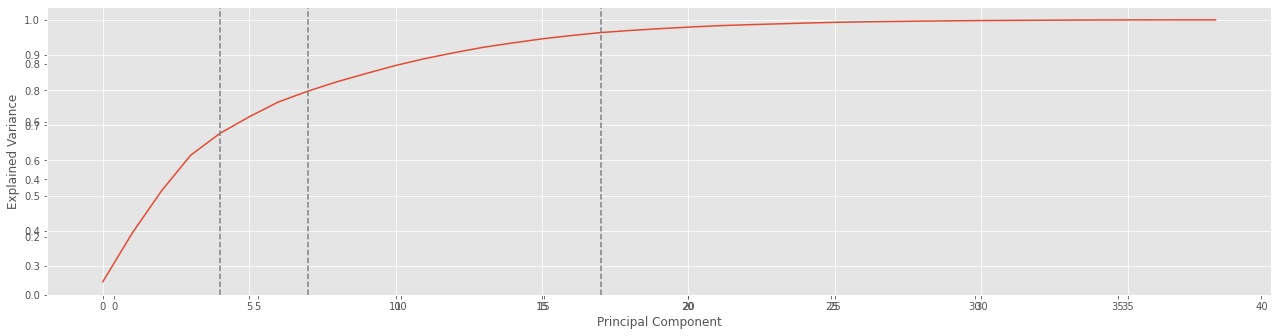

Minimum n_components required for 55% explained variance: 4
Minimum n_components required for 75% explained variance: 7
Minimum n_components required for 95% explained variance: 17


In [98]:
# Investigate the variance accounted for by each principal component

fig = plt.figure(figsize=(17,4))

ax1 = fig.add_axes([0,0,1,1])
ax1.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)

ax2 = fig.add_axes([0,0,1,1])
ax2.plot(np.cumsum(pca.explained_variance_ratio_))

ev_list = [0.55, 0.75, 0.95]
n_components_list = []

for ev in ev_list:
    n_components = min(np.where(np.cumsum(pca.explained_variance_ratio_)>ev)[0]+1)
    ax1.axhline(ev, linestyle='dashed', color='grey')
    ax2.axvline(n_components, linestyle='dashed', color='grey')
    n_components_list.append(n_components)

plt.xlabel("Principal Component")
plt.ylabel("Explained Variance")

plt.show()

for ev, nc in zip(ev_list, n_components_list):
    print(f'Minimum n_components required for {int(ev*100)}% explained variance: {nc}')

The aim here is use a sufficient percentage to capture the majority of the variability in the data while keeping number of principal components reasonably small. In this particular case, since the original dataframe has only 39 features which in itself is small, 95% explained variance will be used.

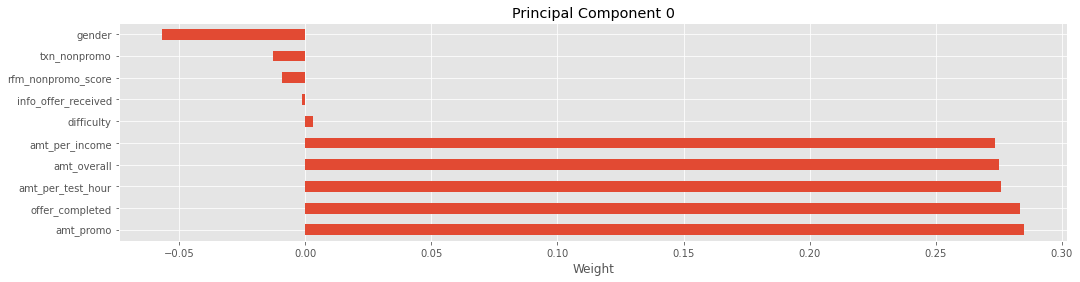

In [99]:
# Investigate the first principal component
u.plot_pca_component(coe, pca, 0)

The first principal component is associated largely with features in relation to customer's gender, amount spent in promotional durations, number offer completed, and also avengers spent per test hour and per income. 

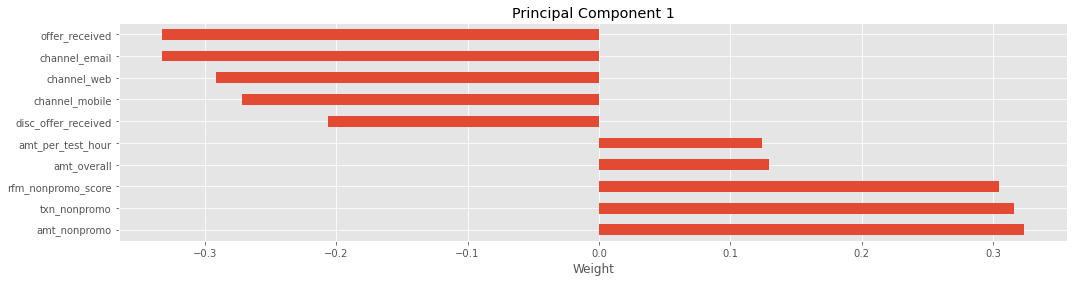

In [100]:
# Investigate the second principal component
u.plot_pca_component(coe, pca, 1)

The second principal component is largely associated with total number of offer received by a customer and their communication channels. Also, puts a lot of weight on activities outside of promotional durations.

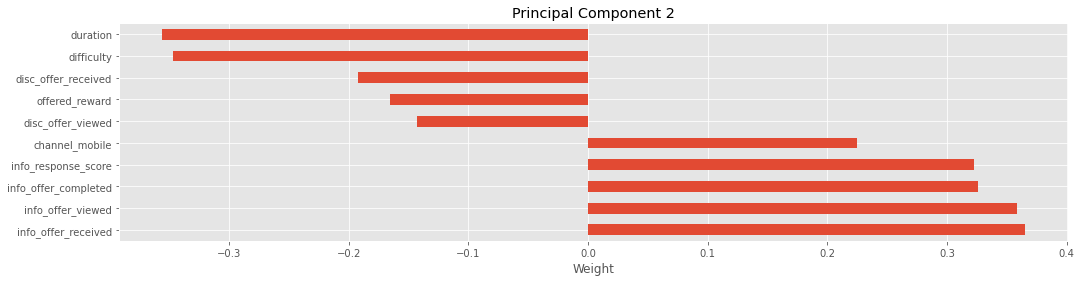

In [101]:
# Investigate the third principal component
u.plot_pca_component(coe, pca, 2)


The third principal component is largely associated with averages of duration and difficulty. Also with 'informational' offers features.

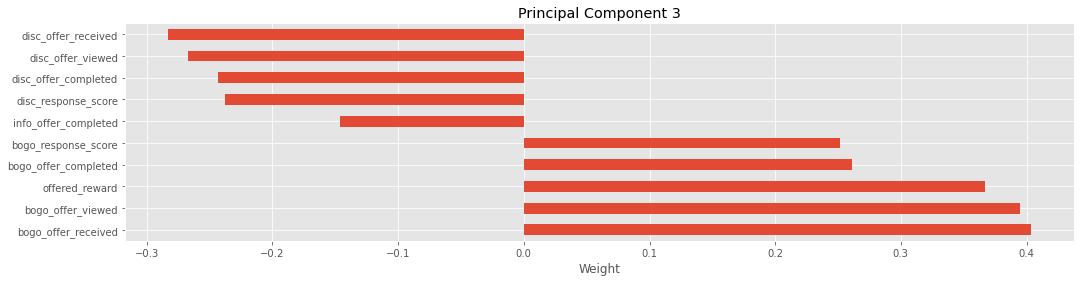

In [102]:
# Investigate the third principal component
u.plot_pca_component(coe, pca, 3)

The fourth principal component is largely associated with 'bogo' and 'discount' offers features.

AttributeError: 'NoneType' object has no attribute 'split'

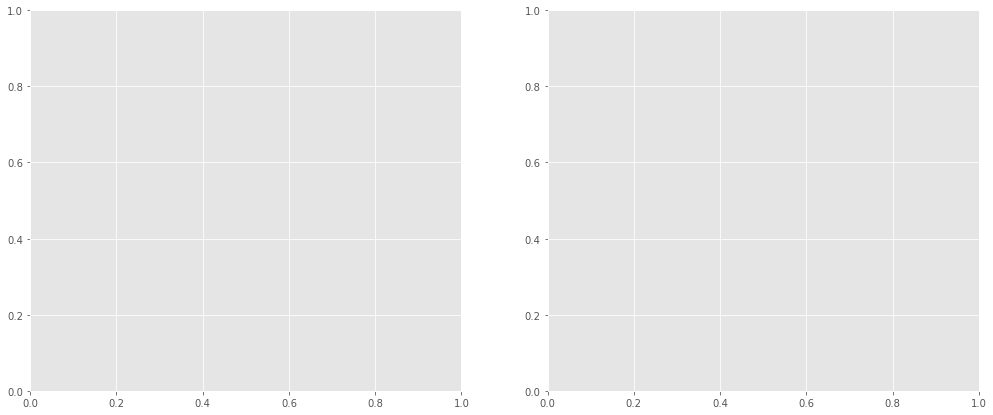

In [104]:
# Investigate change in SC and SSE across number of clusters
u.plot_optimization_analysis(
    df = coe,
    ev = 0.95,
    sample_size = 0.3)

#### 4.2.1. Finding Optimal Number of Clusters

#### First and foremost, the silhouette score is rather low indicating overlapping clusters (indifferent). The “elbow” method is not helpful in this case since there is no clear “elbow”. The silhouette method can be followed rigorously and thus making 2-3 the optimal number of clusters, or a compromise between the two methods can followed leading to an optimal number of 4-7 clusters.

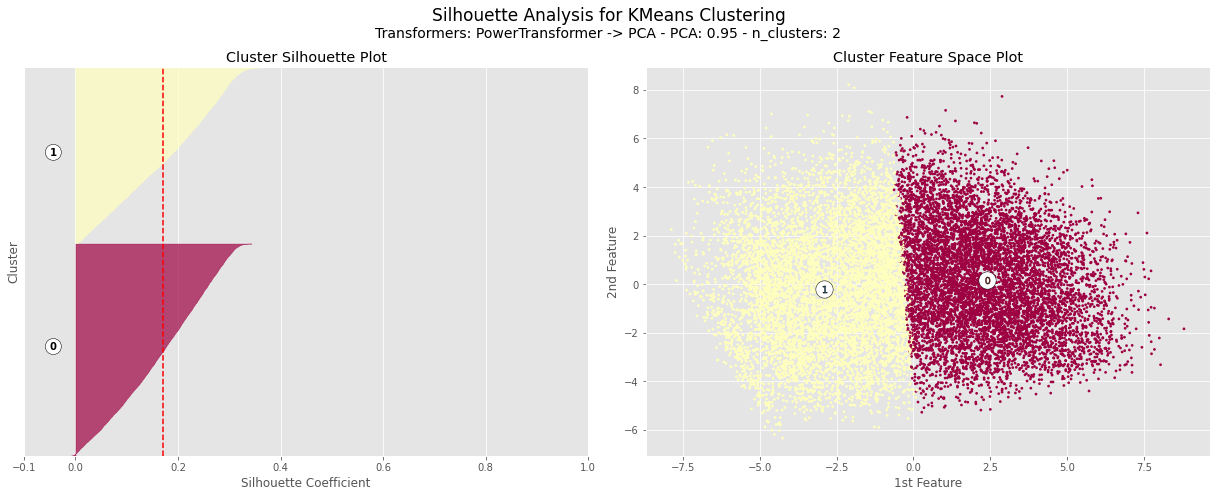

In [105]:
# Investigate silhouette analysis plot with n_clusters=2 
u.plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 2)

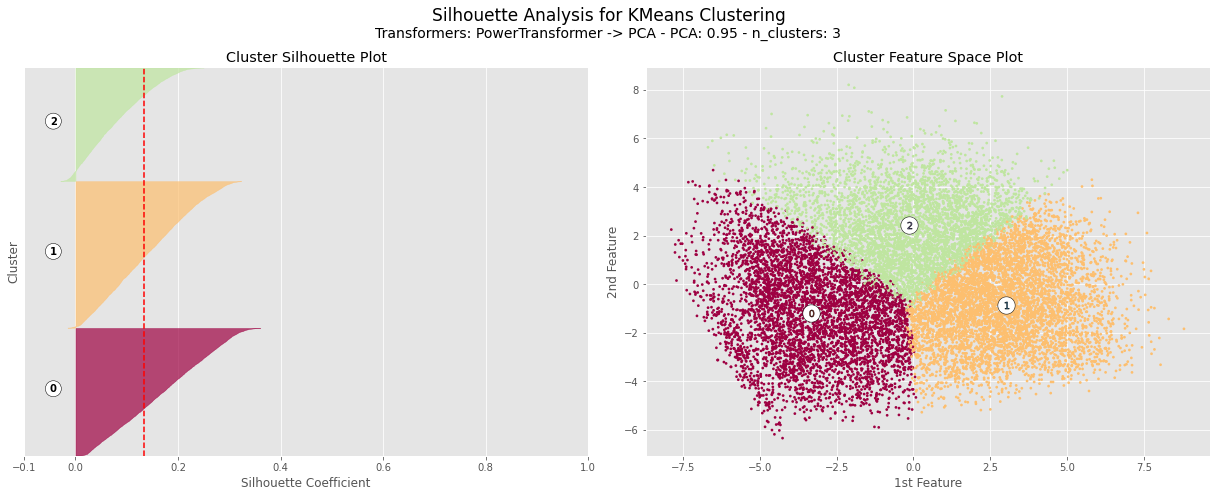

In [106]:
u.plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 3)

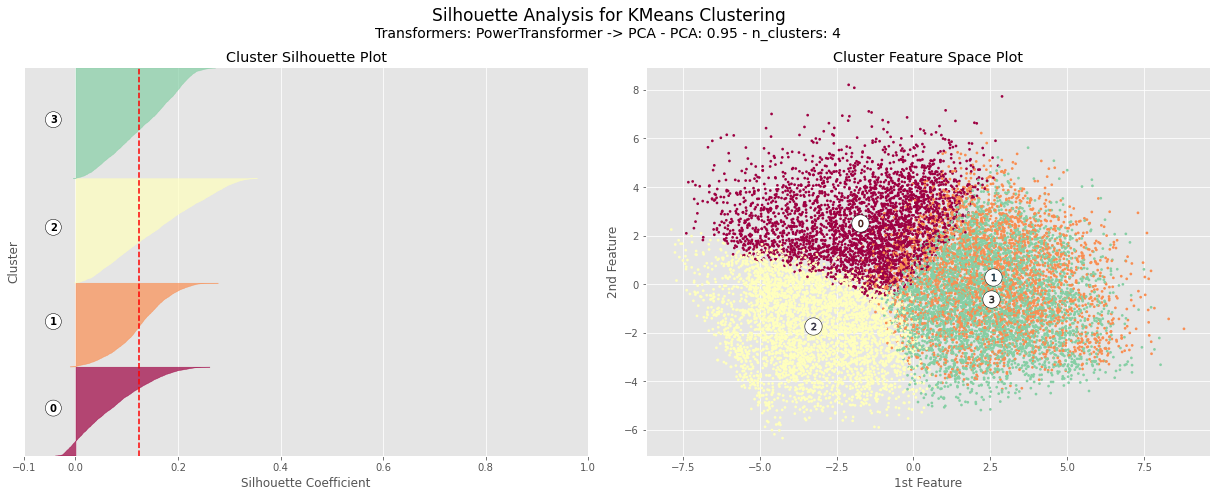

In [107]:
# Investigate s# Investigate silhouette analysis plot with n_clusteilhouette analysis plot with n_clusters=4
# Investigate silhouette analysis plot with n_clusters=4
u.plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 4)

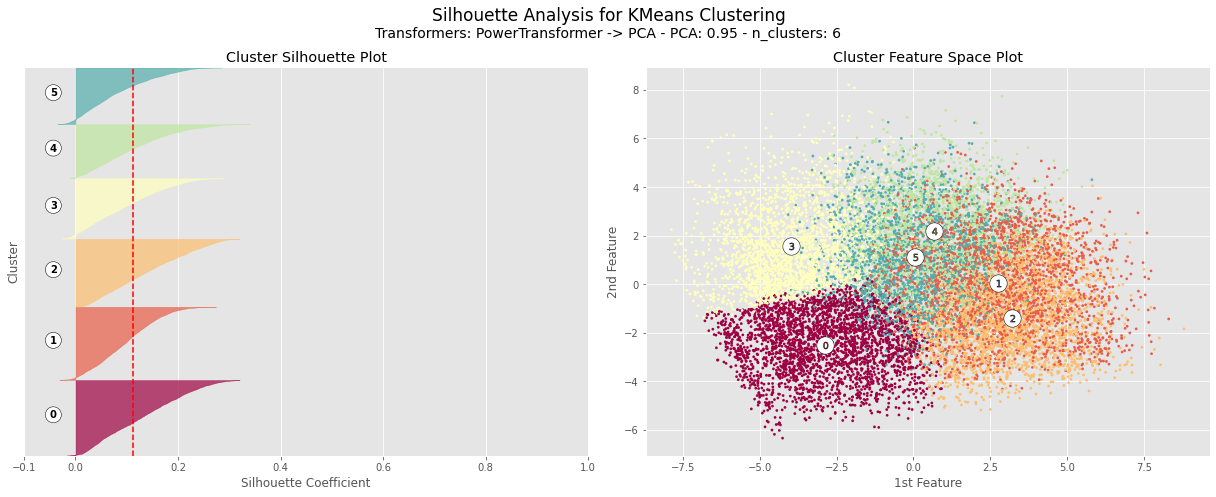

In [108]:
# Investigate silhouette analysis plot with n_clusters=6
u.plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 6)

As it can be seen from the graphs above, 2, 6, and to a lesser extent 3 number of clusters seems to the most reasonable choices. The decision here was to go with 6 clusters for the reasons described above in this section's intro.

#### 4.2.3. Model Implementation

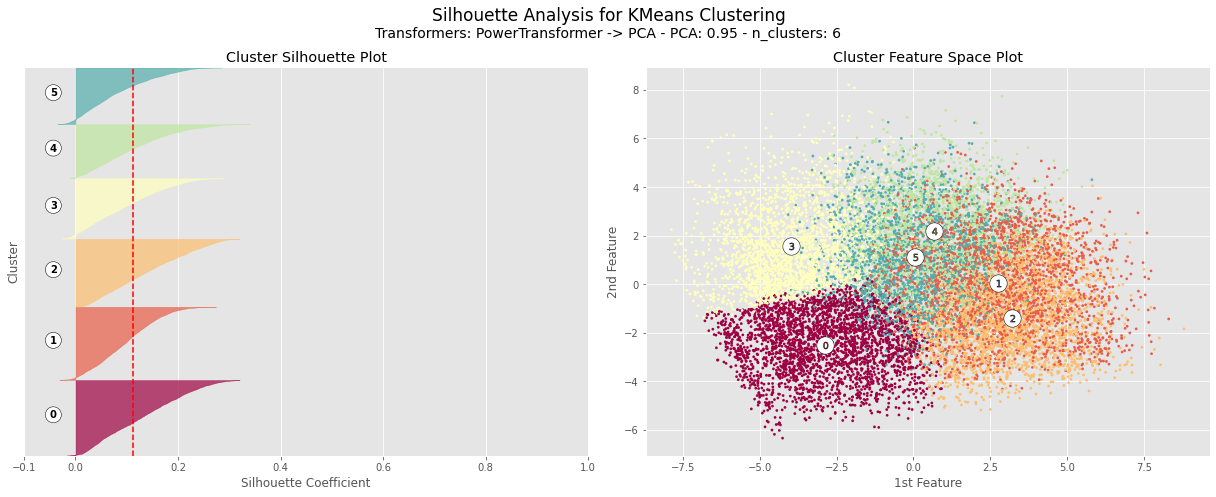

In [109]:
# Investigate silhouette analysis plot with n_clusters=6
u.plot_silhouette_analysis(
    df = coe,
    ev = 0.95,
    n_clusters = 6)

In [110]:
# Set desired parameters
n_clusters = 6
ev = 0.95
est = 'KMeans'

# Transform, fit, and predict
X = u.transform_data(coe, ev)
model, labels = u.fit_predict_data(X, n_clusters, est)

# Store predicted labels in `coe` dataframe
coe['cluster'] = labels

print(f'{est} with {n_clusters} Clusters\n', 'Silhouette Score: ', np.round(silhouette_score(X, labels), 2))

KMeans with 6 Clusters
 Silhouette Score:  0.11


Again, it is worth noting here that the silhouette score (coefficient) is lower than one would have hoped. This indicates overlapping clusters or the data is not clustrable. Nonetheless, outcome clusters will be investigated below.

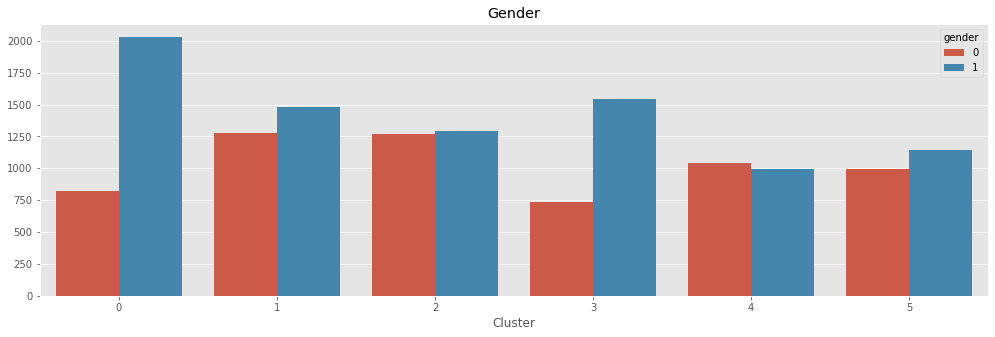

 cluster  mean  min  median  max
       0  0.71  0.0     1.0  1.0
       1  0.54  0.0     1.0  1.0
       2  0.51  0.0     1.0  1.0
       3  0.68  0.0     1.0  1.0
       4  0.49  0.0     0.0  1.0
       5  0.54  0.0     1.0  1.0


In [111]:
# Investigate `gender` distribution in clusters
u.plot_cluster_analysis(plot='countplot', df=coe,
                        target_columns='gender',
                        title='Gender')

Column gender is a categorical variable so descriptive statistics in this case are arbitrary, but since females are represented by 0 and males by 1, the mean would tell about gender distrbution in a cluster. If mean is about 0.5 then both genders are equally represented in the cluster which is the case for all clusters except clusters 1 and 5 where males are overrepresented. Overall, the model does a decent job in avoiding clusters formation based on gender type.

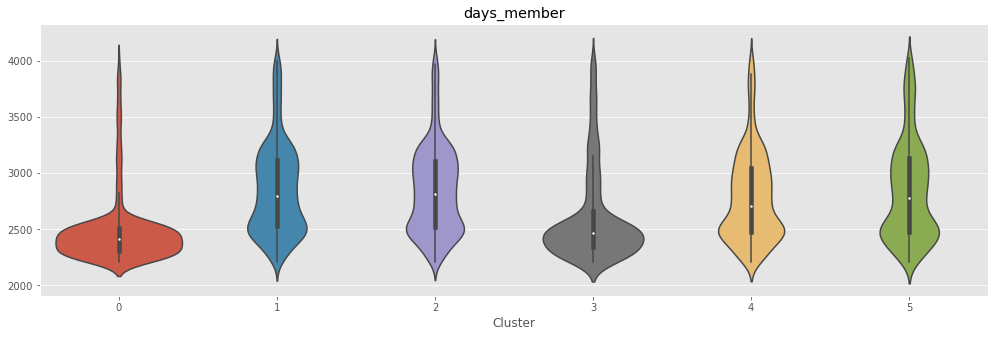

 cluster    mean    min  median    max
       0 2484.11 2210.0  2413.0 4020.0
       1 2858.39 2210.0  2797.0 4032.0
       2 2848.78 2210.0  2811.0 4033.0
       3 2607.60 2210.0  2471.0 4032.0
       4 2787.04 2210.0  2711.0 4032.0
       5 2846.64 2210.0  2776.0 4029.0


In [112]:
# Investigate `age`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='days_member',
                        title='days_member')

Looking at days_member, all clusters seem to be formed of similar members in terms of seniority except for clusters 1 and 5 where they are about 200-300 days less in seniority.

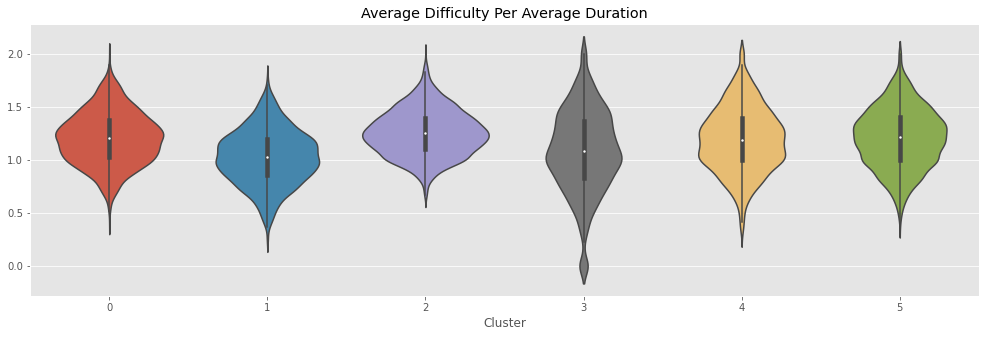

 cluster  mean  min  median  max
       0  1.21 0.40    1.21 2.00
       1  1.03 0.24    1.03 1.79
       2  1.26 0.65    1.25 2.00
       3  1.08 0.00    1.08 2.00
       4  1.19 0.31    1.19 2.00
       5  1.21 0.39    1.21 2.00


In [113]:
# Investigate average `difficulty` per average `duration`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['duration', 'difficulty'],
                        title='Average Difficulty Per Average Duration')

Another important metric is to see if all clusters were fairly treated in terms of difficulty of offers received. By calculating the average difficulty per average duration for each customer for all offers received, it can be seen that on average all clusters received a difficulty of about $1 per day in duration.

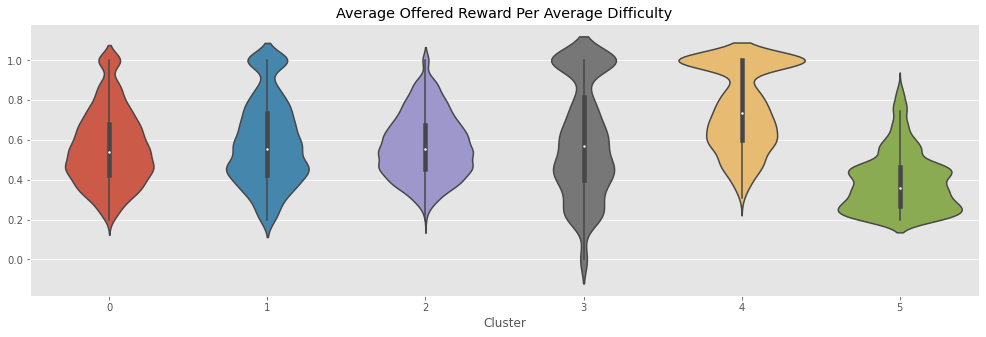

 cluster  mean  min  median  max
       0  0.56 0.20    0.54 1.00
       1  0.59 0.20    0.56 1.00
       2  0.57 0.20    0.56 1.00
       3  0.59 0.00    0.57 1.00
       4  0.76 0.31    0.73 1.00
       5  0.39 0.20    0.36 0.88


In [114]:
# Investigate average `offered_reward` per average `difficulty`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['difficulty', 'offered_reward'],
                        title='Average Offered Reward Per Average Difficulty')

Similarly, by calculating the the average reward per average difficulty for each customer for all offers received, it can be seen that cluster 3 enjoys highest rate. That means the company offered to reward customers in this cluster with 76¢ on the dollar assuming the offer is completed. Followed by clusters 1, 2, 3, and 5 with about 60¢ on the dollar. Last comes cluster 0 with about 40¢ on the dollar.

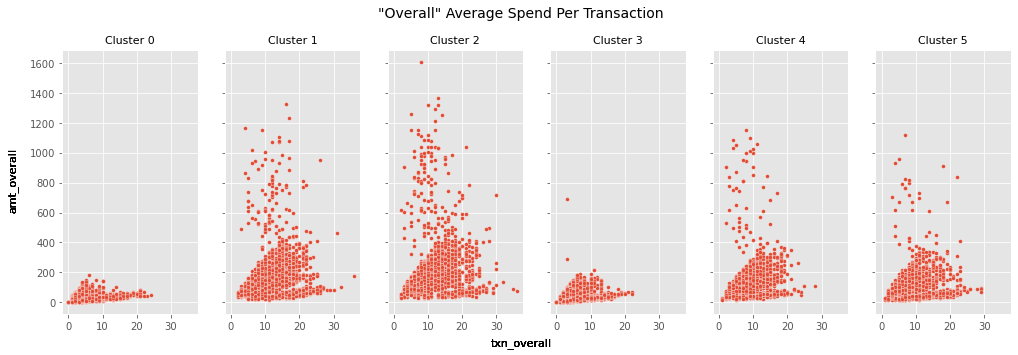

 cluster  mean  min  median    max
       0  6.70 0.00    3.28  50.08
       1 17.19 1.65   15.96 291.32
       2 21.20 1.60   18.83 307.93
       3  8.76 0.00    3.79 231.27
       4 20.32 1.67   18.68 451.47
       5 16.85 1.42   16.67 234.63


In [115]:
# Investigate "overall" average spend per transaction
u.plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_overall', 'amt_overall'],
                        title='"Overall" Average Spend Per Transaction')


Looking at amt_overall per txn_overall (average spend per transaction), all clusters exhibit similar numbers except for clusters 1 and 5 with very low numbers. These two clusters are affected by customers who never made any transaction (from now on, will be referred to as "idle customers") as it can be seen from the minimum. Idle customers represent 3.3% and 8.9% in clusters 3 and 4 respectively as confirmed below.

In [116]:
# Investigate idle customers (with zero transactions) in `txn_overall`
u.compute_nil_pct(df=coe, target_column='txn_overall')

 cluster  pct
       0  8.9
       1  0.0
       2  0.0
       3  3.2
       4  0.0
       5  0.0


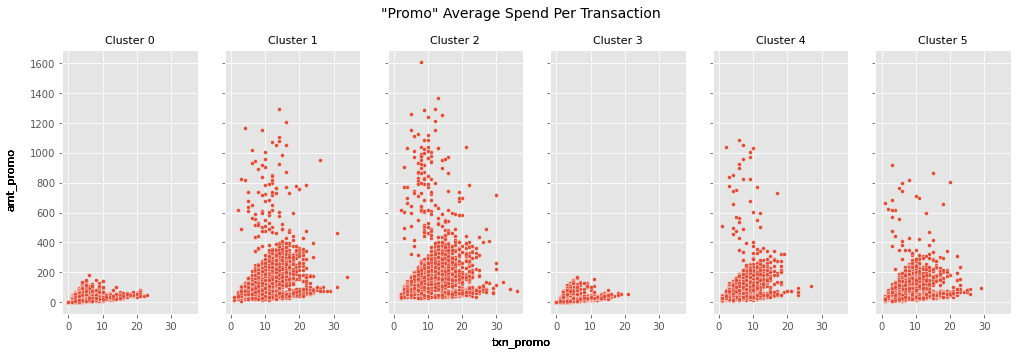

 cluster  mean  min  median    max
       0  6.58 0.00    3.24  50.08
       1 17.22 1.65   15.95 307.20
       2 21.36 1.60   18.76 307.93
       3  7.57 0.00    3.42  39.22
       4 20.11 1.74   18.45 518.32
       5 17.33 1.41   16.63 666.86


In [117]:
# Investigate "promo" average spend per transaction
u.plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_promo', 'amt_promo'],
                        title='"Promo" Average Spend Per Transaction')

Since most transactions in the dataset are made during promotion periods, amt_promo per txn_promo tend to project comparable numbers to overall. Again, similar numbers for all clusters except for clusters 1 and 5 with very low numbers and idle customers percentages of 9.3% and 9.6% respectively.

# Investigate idle customers (with zero transactions) in `txn_promo`
u.compute_nil_pct(df=coe, target_column='txn_promo')

In [118]:
# Investigate idle customers (with zero transactions) in `txn_promo`
u.compute_nil_pct(df=coe, target_column='txn_promo')

 cluster  pct
       0  9.6
       1  0.0
       2  0.0
       3  9.1
       4  0.0
       5  0.0


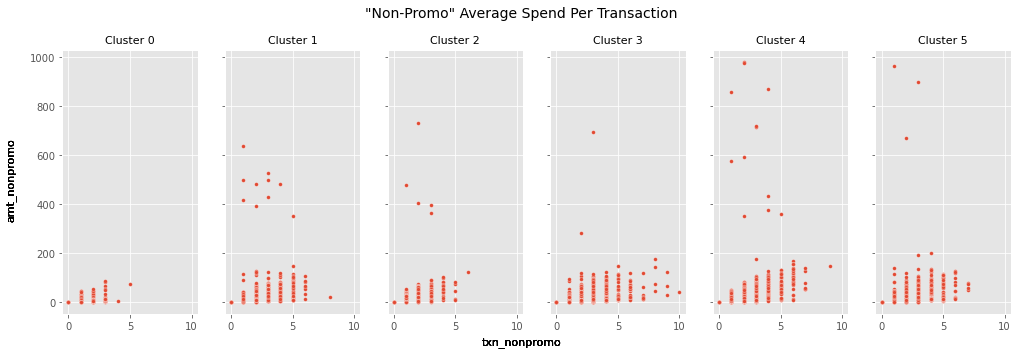

 cluster  mean  min  median    max
       0  1.25  0.0    0.00  46.67
       1  8.93  0.0    2.67 635.06
       2  5.56  0.0    0.00 476.33
       3  7.66  0.0    3.46 231.27
       4 16.74  0.0   15.28 855.31
       5 11.67  0.0    8.25 962.10


In [119]:
# Investigate "nonpromo" average spend per transaction
u.plot_cluster_analysis(plot='scatterplot', df=coe,
                        target_columns=['txn_nonpromo', 'amt_nonpromo'],
                        title='"Non-Promo" Average Spend Per Transaction')

In amt_nonpromo per txn_nonpromo, significant difference between clusters. Cluster 3 with the highest spend per transaction in non-promotional periods, and followed by cluster 1. In contrast, cluster 5 with a mean of $1.23 per transaction and a maximum of $46.67. This starts to indicate which customers are actively spending during non-promotional periods and which customers need to be promoted to do so. All clusters suffer from idle customers but to different degrees as it can be seen below.

In [120]:
# Investigate idle customers (with zero transactions) in `txn_nonpromo`
u.compute_nil_pct(df=coe, target_column='txn_nonpromo')

 cluster  pct
       0 78.7
       1 44.3
       2 68.7
       3 16.5
       4 13.5
       5 27.0


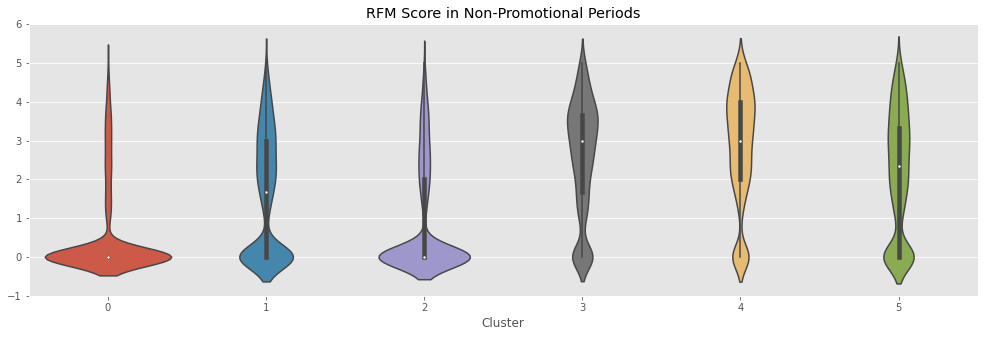

 cluster  mean  min  median  max
       0  0.56  0.0    0.00  5.0
       1  1.55  0.0    1.67  5.0
       2  0.87  0.0    0.00  5.0
       3  2.58  0.0    3.00  5.0
       4  2.86  0.0    3.00  5.0
       5  2.15  0.0    2.33  5.0


In [121]:
# Investigate RFM score in non-promotional periods
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='rfm_nonpromo_score',
                        title='RFM Score in Non-Promotional Periods')

In non-promotional periods, cluster 3 are most valuable to business with a mean RFM score of 2.83 and median of 3.00. Followed by cluster 1 with a mean RFM score of 2.58 and median of 3.00. Clusters 4 and 5 with the least value during non-promotional periods with a mean RFM score of 0.89 and 0.56 respectively and both medians at 0.

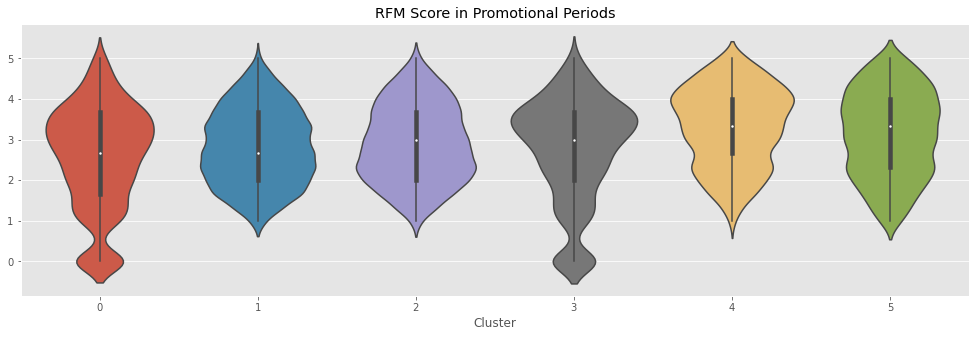

 cluster  mean  min  median  max
       0  2.58  0.0    2.67  5.0
       1  2.83  1.0    2.67  5.0
       2  2.90  1.0    3.00  5.0
       3  2.76  0.0    3.00  5.0
       4  3.31  1.0    3.33  5.0
       5  3.14  1.0    3.33  5.0


In [122]:
# # Investigate RFM score in promotional periods
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='rfm_promo_score',
                        title='RFM Score in Promotional Periods')

In [123]:
# Investigate percentage change in center measurements
# between `rfm_nonpromo_score` and `rfm_promo_score`
u.compute_percentage_change(coe, 'rfm_nonpromo_score', 'rfm_promo_score')

 cluster  mean_initial  mean_final  mean_%chnage  median_initial  median_final  median_%chnage
       0          0.56        2.58        360.71            0.00          2.67             inf
       1          1.55        2.83         82.58            1.67          2.67           59.88
       2          0.87        2.90        233.33            0.00          3.00             inf
       3          2.58        2.76          6.98            3.00          3.00            0.00
       4          2.86        3.31         15.73            3.00          3.33           11.00
       5          2.15        3.14         46.05            2.33          3.33           42.92


Considering RFM scores in non-promotional periods as an "initial" values and RFM scores in promotional periods as "final" values, percentage change from non-promotional to promotional periods can be computed to give better understanding. For example, cluster 3 with relatively high RFM score in non-promotional periods display an increase of 17% and 11% in mean and median respectively during promotional periods. This indicates that customers in this cluster are active spenders even when not promoted to do so. Clusters 4 and 5 on the other hand exhibit a big chnage with about 226% and 360% in mean respectively. The median is "inf" because initial value (denominator) is zero, yet the big change can be easily noticed. This indicates that customers in these two clusters should be the prime target for promotions. Another cluster to look at is cluster 1 where their mean and median RFM scores are either the same or almost the same between the two periods. This indicates that customers in this cluster are indifferent to promotions.

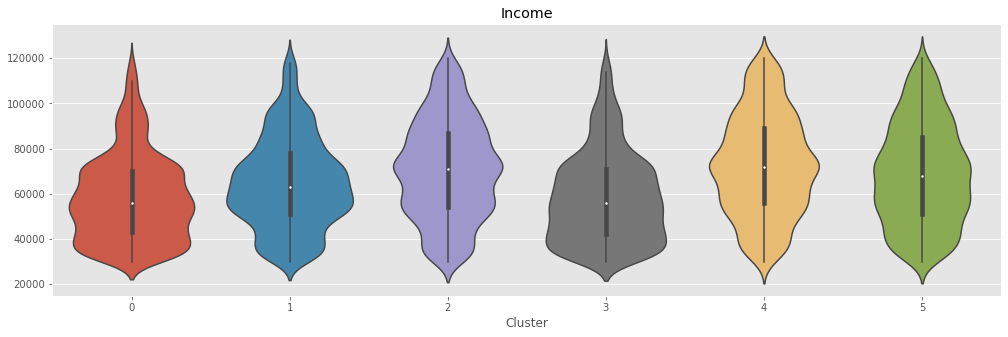

 cluster     mean     min  median      max
       0 58581.40 30000.0 56000.0 119000.0
       1 64944.87 30000.0 63000.0 120000.0
       2 70894.49 30000.0 71000.0 120000.0
       3 58767.57 30000.0 56000.0 120000.0
       4 72721.32 30000.0 72000.0 120000.0
       5 68867.45 30000.0 68000.0 120000.0


In [124]:
# Investigate `income`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='income',
                        title='Income')

Investigating income supports the narrative above to some extent. Cluster 3 with the highest mean income of $72,920 explaining their high activity during non-promotional periods. It worth noting cluster 4 which is the second highest income group, but these costumes were one of the lowest active during non-promotional periods and only active if promoted to do so. In contrast, while cluster 1 mean income is low, there are moderately active between the two periods as discussed above.


Taking a look at view and completion rates as percentage of all offers received. It can be seen that all clusters have moderate to high view rates, with the lowest being 59% for cluster 4 and the highest being 85% for cluster 2. Completion rates however are 67% and 61% for clusters 2 and 4 respectively, 53% and 48% for clusters 3 and 0 respectively, and badly low 13% and 12% for clusters 5 and 1 respectively.

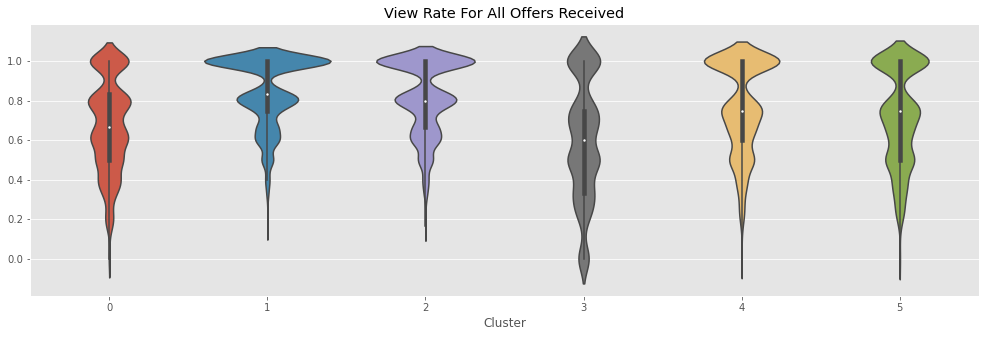

 cluster  mean  min  median  max
       0  0.67 0.00    0.67  1.0
       1  0.85 0.17    0.83  1.0
       2  0.82 0.17    0.80  1.0
       3  0.60 0.00    0.60  1.0
       4  0.77 0.00    0.75  1.0
       5  0.72 0.00    0.75  1.0


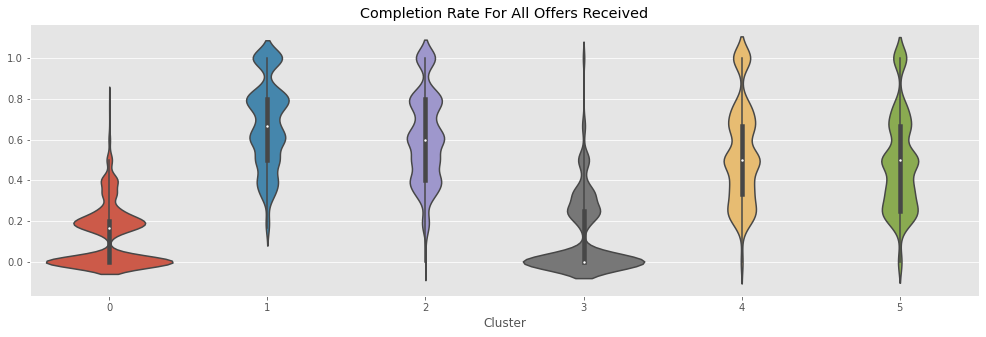

 cluster  mean  min  median  max
       0  0.13 0.00    0.17  0.8
       1  0.67 0.17    0.67  1.0
       2  0.61 0.00    0.60  1.0
       3  0.13 0.00    0.00  1.0
       4  0.53 0.00    0.50  1.0
       5  0.48 0.00    0.50  1.0


In [125]:
# Investigate viewership and completion rates as percentage of all offers received
for column, title in zip(['offer_viewed', 'offer_completed'], ['View', 'Completion']):
    u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['offer_received', column],
                        title=f'{title} Rate For All Offers Received')

Taking a look at view and completion rates as percentage of all offers received. It can be seen that all clusters have moderate to high view rates, with the lowest being 59% for cluster 4 and the highest being 85% for cluster 2. Completion rates however are 67% and 61% for clusters 2 and 4 respectively, 53% and 48% for clusters 3 and 0 respectively, and badly low 13% and 12% for clusters 5 and 1 respectively.

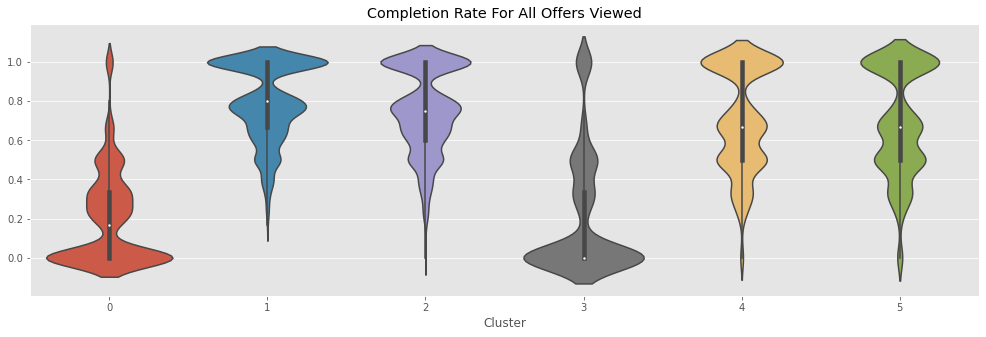

 cluster  mean  min  median  max
       0  0.20 0.00    0.17  1.0
       1  0.79 0.17    0.80  1.0
       2  0.75 0.00    0.75  1.0
       3  0.21 0.00    0.00  1.0
       4  0.71 0.00    0.67  1.0
       5  0.69 0.00    0.67  1.0


In [126]:
# Investigate completion rates as percentage of all offers viewed 
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['offer_viewed', 'offer_completed'],
                        title='Completion Rate For All Offers Viewed')

Looking at completion rate for all offers as a percentage of offers viewed (not received). Clusters 0, 2, 3, and 4 completed around 70-80% of all offers they have viewed. Clusters 1 and 5 only completed about 20% of all offers they have viewed.

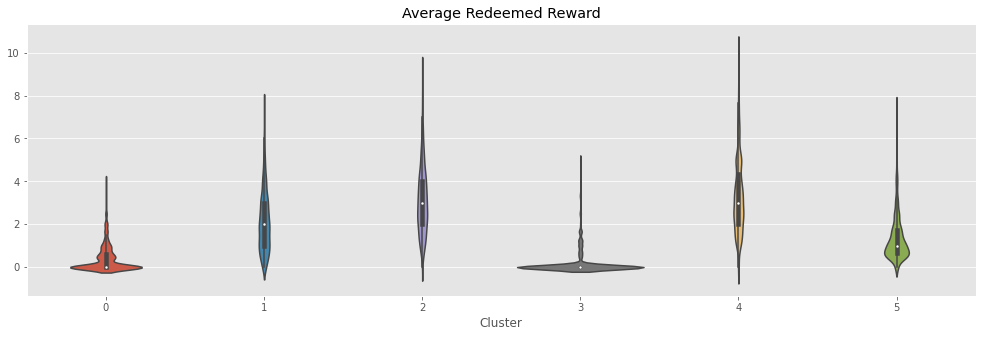

 cluster  mean  min  median   max
       0  0.39  0.0     0.0  4.00
       1  2.13  0.0     2.0  7.50
       2  3.11  0.0     3.0  9.17
       3  0.16  0.0     0.0  5.00
       4  3.33  0.0     3.0 10.00
       5  1.34  0.0     1.0  7.50


In [127]:
# Investigate average `redeemed_reward`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='redeemed_reward',
                        title='Average Redeemed Reward')


Looking at average redeemed_reward for all offers completed, clusters 3 and 4 with the highest redeemed rewards of $3.31 and $3.12 respectively. Clusters 5 and 1 with the lowest being $0.38 and $0.15 respectively.

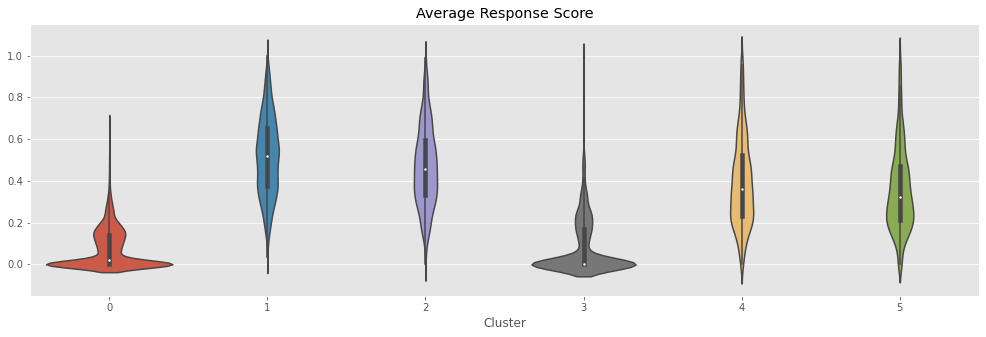

 cluster  mean  min  median  max
       0  0.07 0.00    0.02 0.68
       1  0.52 0.03    0.52 1.00
       2  0.47 0.00    0.46 0.99
       3  0.08 0.00    0.00 1.00
       4  0.39 0.00    0.36 1.00
       5  0.36 0.00    0.32 1.00


In [128]:
# Investigate average `response_score`
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns='response_score',
                        title='Average Response Score')

Looking at response_score, which again measures how fast a customer react to an offer with 1 being fastest, it can be seen that cluster 2 are fastest with 0.52 mean (and median) response score. Followed by cluster 4 with a mean of 0.47 response score. It worth noting cluster 1 and 5 which exhibit a very low mean of 0.08 and 0.07 response score respectively.

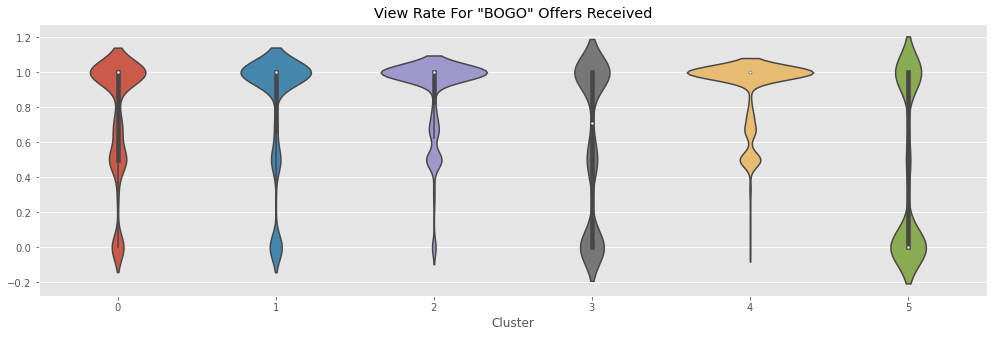

 cluster  mean  min  median  max
       0  0.74  0.0    1.00  1.0
       1  0.81  0.0    1.00  1.0
       2  0.88  0.0    1.00  1.0
       3  0.58  0.0    0.71  1.0
       4  0.90  0.0    1.00  1.0
       5  0.43  0.0    0.00  1.0


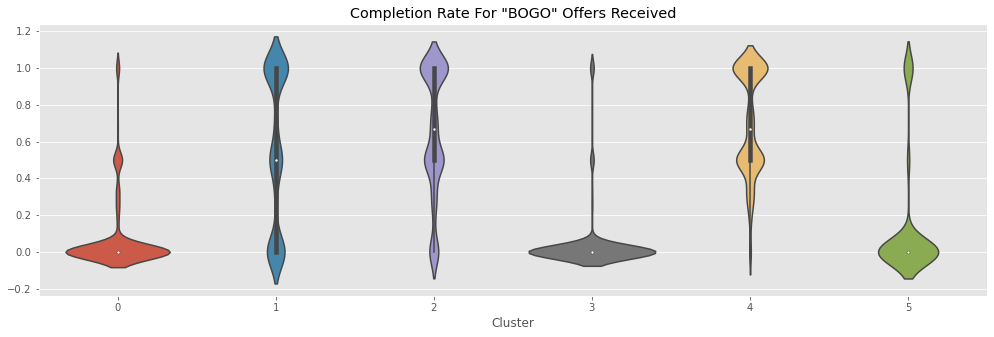

 cluster  mean  min  median  max
       0  0.08  0.0    0.00  1.0
       1  0.56  0.0    0.50  1.0
       2  0.64  0.0    0.67  1.0
       3  0.04  0.0    0.00  1.0
       4  0.70  0.0    0.67  1.0
       5  0.14  0.0    0.00  1.0


In [129]:
# Investigate viewership and completion rates as percentage of "bogo" offers received
for column, title in zip(['bogo_offer_viewed', 'bogo_offer_completed'], ['View', 'Completion']):
    u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['bogo_offer_received', column],
                        title=f'{title} Rate For "BOGO" Offers Received')

Looking at view and completion rates for "bogo" offers, all clusters have relatively high view rate with the lowesest being 43% for cluster 0 but completion rates varies. Actually, clusters 2, 3, and 4 have 80-90% view rates and 55-70% completion rates indicating these clusters do in fact like "bogo" offers. For clusters 1 and 5, view rates are around 55-75% but completion rates are severely low with 4% and 8% respectively which leads to the assumtion that these customers might feel indifferent towards "bogo" offers. Similar argument can be made regarding cluster 0.

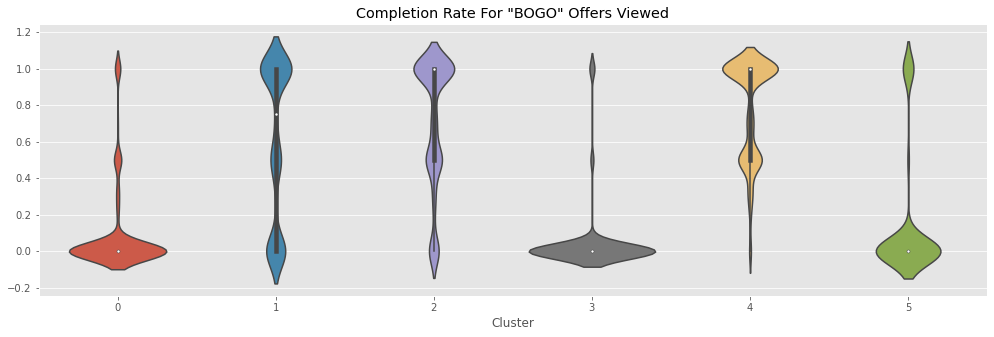

 cluster  mean  min  median  max
       0  0.09  0.0    0.00  1.0
       1  0.60  0.0    0.75  1.0
       2  0.71  0.0    1.00  1.0
       3  0.05  0.0    0.00  1.0
       4  0.79  0.0    1.00  1.0
       5  0.15  0.0    0.00  1.0


In [130]:
# Investigate completion rates as percentage of "bogo" offers viewed 
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['bogo_offer_viewed', 'bogo_offer_completed'],
                        title='Completion Rate For "BOGO" Offers Viewed')


Here, looking at completion rate for "bogo" offers as a percentage of offers viewed. Again, clusters 2, 3, 4 completed 60-78% of all 'bogo' offers they have viewed. Clusters 0, 1, 5 only completed 5-15% of all 'bogo' offers they have viewed.

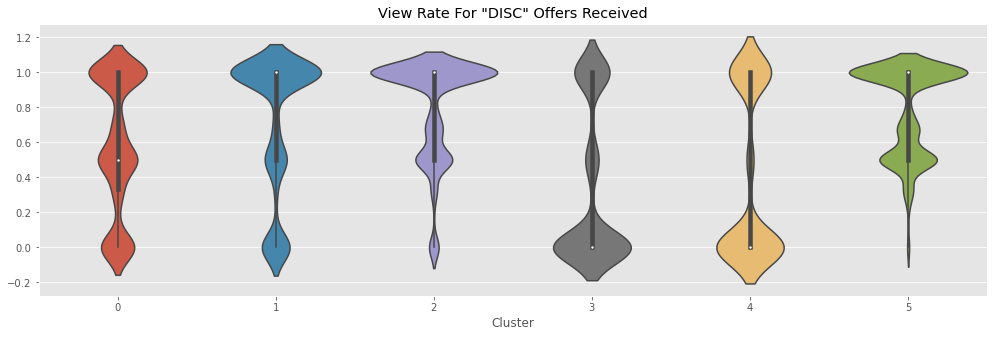

 cluster  mean  min  median  max
       0  0.58  0.0     0.5  1.0
       1  0.72  0.0     1.0  1.0
       2  0.81  0.0     1.0  1.0
       3  0.33  0.0     0.0  1.0
       4  0.39  0.0     0.0  1.0
       5  0.78  0.0     1.0  1.0


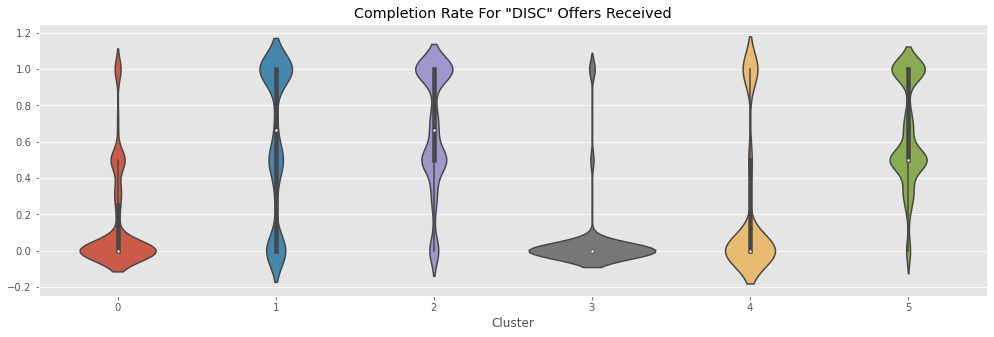

 cluster  mean  min  median  max
       0  0.16  0.0    0.00  1.0
       1  0.60  0.0    0.67  1.0
       2  0.67  0.0    0.67  1.0
       3  0.05  0.0    0.00  1.0
       4  0.24  0.0    0.00  1.0
       5  0.65  0.0    0.50  1.0


In [131]:
# Investigate viewership and completion rates as percentage of "disc" offers received
for column, title in zip(['disc_offer_viewed', 'disc_offer_completed'], ['View', 'Completion']):
    u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['disc_offer_received', column],
                        title=f'{title} Rate For "DISC" Offers Received')

In similar manner, for "disc" offers, clusters 0, 2, and 4 have view rates around 70-81% and completion rates around 60-67% indicating strong interest in "disc" offers. Clusters 0 and 4 have view rates around 33-38% and completion rates around 5-23%. Seeing cluster 5 while at 58% view rate is only at 15% completion rate suggests no interest in 'disc" offers.

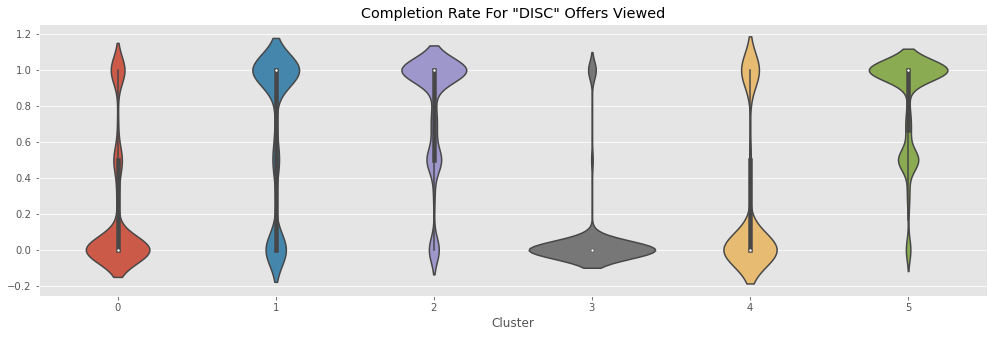

 cluster  mean  min  median  max
       0  0.22  0.0     0.0  1.0
       1  0.68  0.0     1.0  1.0
       2  0.79  0.0     1.0  1.0
       3  0.06  0.0     0.0  1.0
       4  0.26  0.0     0.0  1.0
       5  0.83  0.0     1.0  1.0


In [132]:
# Investigate completion rates as percentage of "disc" offers viewed 
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['disc_offer_viewed', 'disc_offer_completed'],
                        title='Completion Rate For "DISC" Offers Viewed')


Looking at completion rate for "disc" offers as percentage of offers viewed. Again, clusters 0, 4, 2 completed around 68-83% of all 'disc' offers they have viewed. It worth noting, cluster 0 while previously not interested in "bogo" offers are now leading "disc" completion rates with 83%. Clusters 1, 3, and 5 only completed 6-24% of all 'disc' offers they have viewed (cluster 3 was leading completion rates for "bogo" offers).

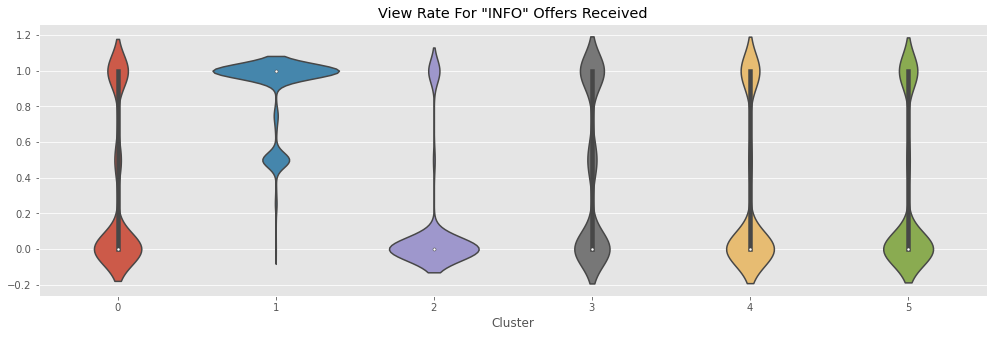

 cluster  mean  min  median  max
       0  0.32  0.0     0.0  1.0
       1  0.90  0.0     1.0  1.0
       2  0.12  0.0     0.0  1.0
       3  0.42  0.0     0.0  1.0
       4  0.29  0.0     0.0  1.0
       5  0.28  0.0     0.0  1.0


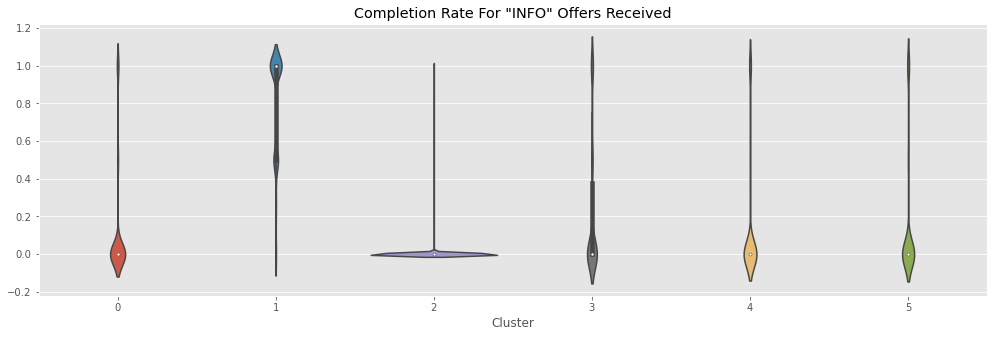

 cluster  mean  min  median  max
       0  0.11  0.0     0.0  1.0
       1  0.81  0.0     1.0  1.0
       2  0.00  0.0     0.0  1.0
       3  0.20  0.0     0.0  1.0
       4  0.13  0.0     0.0  1.0
       5  0.14  0.0     0.0  1.0


In [133]:
# Investigate viewership and completion rates as percentage of "info" offers received
for column, title in zip(['info_offer_viewed', 'info_offer_completed'], ['View', 'Completion']):
    u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['info_offer_received', column],
                        title=f'{title} Rate For "INFO" Offers Received')

Understandably, reactivity to "info" offers is not the same as "bogo" or "disc. However, worth noting cluster 2 which has 90% view rate and 81% completion rate for all "info" offers they have received. This cluster reacts preferably to "info" offers. Remaining clusters are low to moderate view and completion rates with cluster 4 in specific at 12% view rate and 0% completion rate.

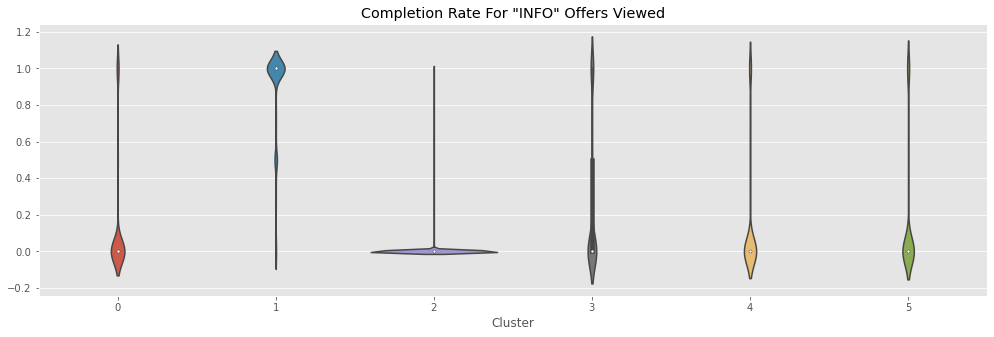

 cluster  mean  min  median  max
       0  0.13  0.0     0.0  1.0
       1  0.90  0.0     1.0  1.0
       2  0.00  0.0     0.0  1.0
       3  0.24  0.0     0.0  1.0
       4  0.13  0.0     0.0  1.0
       5  0.15  0.0     0.0  1.0


In [135]:
# Investigate completion rates as percentage of "info" offers viewed 
u.plot_cluster_analysis(plot='violinplot', df=coe,
                        target_columns=['info_offer_viewed', 'info_offer_completed'],
                        title='Completion Rate For "INFO" Offers Viewed')

Looking at completion rate for "info" offers as percentage of offers viewed. Again, clusters 2 off the charts with 90% completion of all 'info' offers they have viewed. Remaining clusters are about average 10-20% completion rate except cluster 4 with 0% completion rate.

5. Discussion & Conclusion
Now that a better understanding of clusters is formed, it is a good time to reflect on the project as whole. This project started with a lot of data preprocessing on the provided datasets; portfolio, profile, and transcript to produce the final dataset coe ready for modeling. PowerTransformer and PCA transformations were then preformed on coe which was then fed into K-Means clustering algorithm after deciding on 6 number of clusters.

Technically, the silhouette score (coefficient) was disappointedly low at 0.11 indicating overlapping clusters or data not clustrable. However, after evaluating and investigating the clusters formed, it found to be intuitive. Further discussion on improving the silhouette score later in "improvements" section.

5. Discussion & Conclusion
Now that a better understanding of clusters is formed, it is a good time to reflect on the project as whole. This project started with a lot of data preprocessing on the provided datasets; portfolio, profile, and transcript to produce the final dataset coe ready for modeling. PowerTransformer and PCA transformations were then preformed on coe which was then fed into K-Means clustering algorithm after deciding on 6 number of clusters.

Technically, the silhouette score (coefficient) was disappointedly low at 0.11 indicating overlapping clusters or data not clustrable. However, after evaluating and investigating the clusters formed, it found to be intuitive. Further discussion on improving the silhouette score later in "improvements" section.

# 5.1. Model Recommendations

In [136]:
# Create dataframe for important metrics to make recommendations
# according to the main two themes discussed in "problem statement"
reco = pd.DataFrame()

# Get relevant data; collected individually for convenient
# ordering, renaming, and computing of features on the go

reco['cluster'] = coe.cluster
reco['income'] = coe.income
reco['seniority'] = coe.days_member
reco['response'] = coe.response_score
reco['atv_nonpromo'] = coe.amt_nonpromo / coe.txn_nonpromo
reco['atv_promo'] = coe.amt_promo / coe.txn_promo
reco['rfm_nonpromo'] = coe.rfm_nonpromo_score
reco['rfm_promo'] = coe.rfm_promo_score
reco['view_bogo'] = coe.bogo_offer_viewed / coe.bogo_offer_received
reco['view_disc'] = coe.disc_offer_viewed / coe.disc_offer_received
reco['view_info'] = coe.info_offer_viewed / coe.info_offer_received
reco['complete_bogo'] = coe.bogo_offer_completed / coe.bogo_offer_viewed
reco['complete_disc'] = coe.disc_offer_completed / coe.disc_offer_viewed
reco['complete_info'] = coe.info_offer_completed / coe.info_offer_viewed

# Groupby `cluster` and aggregate by mean
reco = reco.groupby('cluster').mean()

# Normalize data feature-wise; this allows to plot
# a heatmap representing marks among formed clusters
reco = pd.DataFrame(MinMaxScaler().fit_transform(reco),
                   columns=reco.columns, index=reco.index)

Nomenclature:

income: average income
seniority: average days as a member of the program
response: average response score
Prefixes
atv_: average transaction value
rfm_: recency, frequency, and monetary score
view_: view rate of offer received
complete_: completion rate of offer viewed
Suffixes
_promo: in promotional periods
_nonpromo: in non-promotional periods
_bogo: "buy one get one" offer type
_disc: "discount" offer type
_info: "informational" offer type

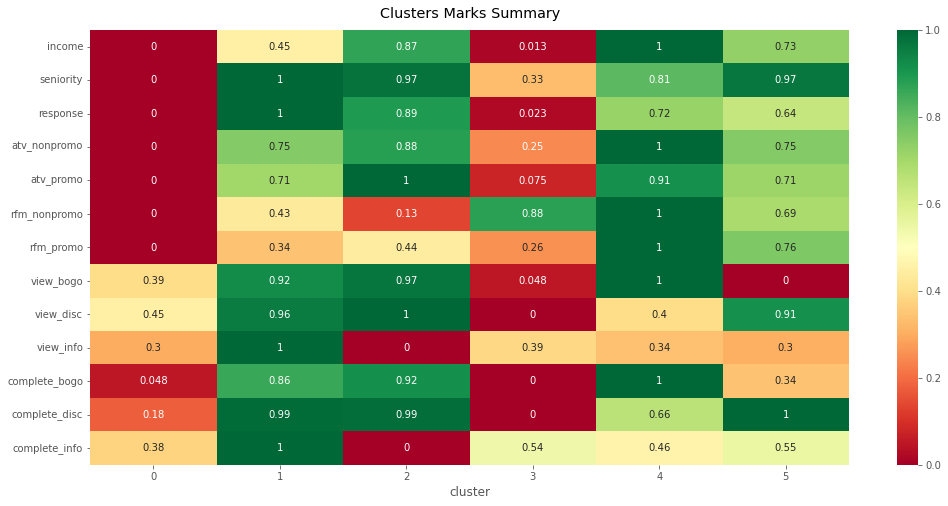

In [137]:
# Plot heatmap
fig = plt.figure(figsize=(17,8))
fig = sns.heatmap(reco.T, annot=True, cmap='RdYlGn')
fig.set_title('Clusters Marks Summary', pad=12)
# Fix issue in matplotlib 3.1.1 where plot is truncated
# https://github.com/matplotlib/matplotlib/issues/14675
fig.set_ylim(len(reco.T), 0)
plt.show()

With the help of the plot above and previously collected data, summary of each cluster is as follows:

**Cluster** `0`: This cluster represents good business value to the company. Their income is fairly high, they are senior members in the program, and they respond fairly quick to offers. They spend an average of \\$11.60 and \\$17.25 in non-promo and promo periods respectively exhibiting an increase in RFM score of 46% between the two periods. This cluster of customers is most interested in "disc" offers being with the best completion rate out of all clusters for these type of offers. They respond fairly to "info" offers, but not so for "bogo" offers.

**Cluster** `1`: This cluster seems to be formed of low-income, low-spenders, and recent-members who does not seem to be tempted by any offer type. Their average spend in both non-promo and promo periods is almost \\$7.50 exhibiting an increase in RFM score of only 6% between the two periods.

**Cluster** `2`: This cluster of customers respond very well to all offers type. In a good way too, with an average spend of \\$8.92 and \\$17.20 in non-promo and promo periods respectively exhibiting an increase in RFM score of 81% between the two periods. They are the most senior members of the program and the fastest to respond to offers. Worth noting in particular, this cluster of customers respond extremely well to "info" offers.

**Cluster** `3`: This cluster of customers arguably represents the best business value for the company non-promo periods. They are the highest spenders in non-promo periods with an average spend of //$16.67 miles ahead of most clusters. Their avergae spend increases to second highest \\$20.34 in promo periods. They have the highest income of all clusters and they respond to offers fairly fast. They are most interested in "bogo" and to a lesser extent "disc" offers, but not so much so for "info" offers.

**Cluster** `4`: This cluster of customer seems to be only active during promo periods. Their average spend in non-promo is low \\$5.66 but that jumps to highest average spend among clusters in promo periods \\$21.23 exhibiting an increase in RFM score of 226% between the two periods. They are equally highly interested in "bogo" and "disc" offers but not tempted by "info" offers at all. They are formed of high income and senior members who respond fast to offers.

**Cluster** `5`: This cluster seems to be formed of customers who are completely inactive during non-promo periods with anvrage spend of lowest \\$1.23. That increase to, still lowest, \\$6.48 average spend in promo periods. Hence an increase in RFM score of 360% but that is due to very low average spend in non-promo periods to begin with. Their view and completion rates are among the lowest if not the lowest. This affects their response score being also among the lowest. Also, does not exhibit a pattern by which it can be said they favor a specific offer type. This cluster of customers seem to be a prime target for further and separate investigation.

### 5.2. Possible Improvements

#### 5.2.1. Communications Channels
One portion of the dataset that was unfortunately not considered probably when doing data preprocessing is the magnitude of communication channels (web, email, mobile, and social) and their effect on viewership and completion rates. The way communication channels were aggregated is quite naive since an offer can be communicated via multiple channels. This made it difficult to construct sensible plots during the analysis of clusters. A more careful approach can be taken in data preprocessing to come up with useful results in this regard.

#### 5.2.2. Silhouette Score

Clearly the most aspect that can be improved is the silhouette score, one way to do that is by redoing data preprocessing in such manner that takes into account this issue. For exmaple, experimenting with using a combination of sparse and dense matrices. Not wanting to redo data preprocessing and after a _massive load_ of searching and reading on the internet, another experiment was conducted using [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) and [GaussianMixture](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

Guided by this [article](https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b), the output of `PCA` (with an explained variance of 0.95) was used as input for `TSNE`. There are many pitfalls with t-SNE, one being that t-SNE does not preserve distances nor density. It only to some extent preserves nearest-neighbors. That's why the choice was to use it with non-distance based clustering techniques like GaussianMixture which is a probabilistic model. Another problem with t-SNE is that tuning its hyperparameters somewhat a matter of a guess. Perplexity is perhaps the most important (and confusing). Guided by this [article](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868), perplexity was set to $N^{1/2}$ where $N$ is the number of samples in the data. The result was an increase of silhouette score to above 0.4. After investigating, the formed clusters do seem intuitive and more or less inline with results obtained by KMeans model. However, unsure of the soundness of this process, following steps are only to show work.

### 5.3. Project Reflection

In this project, I started by exploring the provided dataset to form a better understanding of them. The data cleaning process took quite some time in which I experimented with lots of choices either in terms of decision-making or code-programming. The cleaned datasets were then prepared to form the final dataset grouped by customer profiles. This dataset then went through a few steps of transformation before modeling.

I do hope that all decisions made are correct and justified, although I am sure I have made lots of mistakes along the line which I definitely intend to visit back. While doing the project and by searching onlin material, I read about some subjects for the first time and hence further knowledge expansion in those subjects is on my top to-do list.

Here are some points in particular that I found interesting:
* I like to think that I stepped up my ability in dealing with `for` loops in this project compared with previous work. They are an integral part of  efficient code writing. I used them heavily throughout the project and in different structures to get expected results in reasonable manner and with less code.
* Although I was aware of `pd.apply()` function, I really took it to the next level in this project coming to know more about the power and the flexibility it provides. As it can be seen from the project files, it was my fall-back method when all other methods fail to achieve expected results. It was helpful in extracting information from other dataframes and running logical and mathematical operations as needed. It might not be the best choice when computational cost is critical or if used in this case then needs lots of optimization. As it can be seen although the dataset used in this project is relatively small, the function still took few minutes to complete runs.
* In terms of statistical models, half the time I spent doing this project was in reading online materials in which I realised the field of culturing specifically is vastly huge. My intention is to continue learning in this path. I believe that having extensive understanding of how each model works can have an immense effect on how data is prepared. An example of this was reading and applying `tSNE` transformation with soft clustering `GaussianMixture`.

Overall, I am happy with how this project came to be. I am happy with the number of clusters as 6 clusters are practical from a business perspective. The results of clusters formed after investigation seem intuitive. However, large room for improvement exists.
